In [1]:
from netCDF4 import Dataset  # http://code.google.com/p/netcdf4-python/
import os
####################you will need to change some paths here!#####################
#list of input files
dir_in='f:/data/tc_wakes/database/info/'
dir_out='f:/data/tc_wakes/database/sst/'
dir_mur = 'F:/data/sst/jpl_mur/v4.1/'
#output files
#filename_out_nc='F:/data/cruise_data/saildrone/baja-2018/daily_files/sd-1002/data_so_far.nc'
#filename_out_kml='F:/data/cruise_data/saildrone/baja-2018/daily_files/sd-1002/data_so_far.kml'
#################################################################################
import datetime as dt
import xarray as xr
from datetime import datetime
import pandas
import matplotlib as mpl
#import openpyxl
#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import math
#from math import cos, radians

In [4]:
dir_ccmp='F:/data/sat_data/ccmp/v02.0/Y'
date_1858 = dt.datetime(1858,11,17,0,0,0) # start date is 11/17/1958
dx=0.25
dy=0.25
dx_offset = -179.875
dy_offset = -78.3750
for root, dirs, files in os.walk(dir_in, topdown=False):
#    for ii in range(12,13): 
    lonmin=180
    lonmax=-180
    for name in files:
    #    name = files[ii]
#    for name in files:
        fname_in=os.path.join(root, name)
        fname_out=dir_out + fname_in[31:39] + '_all_25km.nc'
        #print(fname_in[31:35],fname_in[36:39])
        inum_storm=int(fname_in[36:39])
        iyr_storm=int(fname_in[31:35])
        #print(iyr_storm,inum_storm)
        dsx = xr.open_dataset(fname_in)
        lats = dsx.lat
        lons = dsx.lon
        if lonmin>min(lons[0,:].values):
            lonmin=min(lons[0,:].values)
        if lonmax<max(lons[0,:].values):
            lonmax=max(lons[0,:].values)
    print(iyr_storm,lonmin,lonmax)
print(type(lons))

2004 2.4999999441206455 358.0000000447035
2005 0.0 359.00000002235174
2006 38.199999146163464 357.0000000670552
2007 32.899999264627695 353.0000001564622
2008 37.59999915957451 338.10000048950315
2009 33.599999248981476 352.3000001721084
2010 35.09999921545386 345.50000032410026
2011 0.0 353.0000001564622
2012 28.399999365210533 352.50000016763806
2013 37.899999152868986 342.9000003822148
2014 34.19999923557043 345.0000003352761
2015 37.59999915957451 352.3000001721084
2016 43.399999029934406 341.0000004246831
2016 180 -180
<class 'xarray.core.dataarray.DataArray'>


In [3]:
###### dir_mur = 'F:/data/sst/jpl_mur/v4.1/'
dir_ccmp='F:/data/sat_data/ccmp/v02.0/Y'
date_1858 = dt.datetime(1858,11,17,0,0,0) # start date is 11/17/1958
dx=0.25
dy=0.25
dx_offset = -179.875
dy_offset = -78.3750
for root, dirs, files in os.walk(dir_in, topdown=False):
#    for ii in range(12,13): 
    for name in files:
    #    name = files[ii]
#    for name in files:
        fname_in=os.path.join(root, name)
        fname_out=dir_out + fname_in[31:39] + '_all_25km.nc'
        inum_storm=int(fname_in[36:39])
        iyr_storm=int(fname_in[31:35])
        if iyr_storm>2007:
            continue
#        if iyr_storm==2011 and inum_storm<15:
#            continue
        print(name,fname_in)
        dsx = xr.open_dataset(fname_in)
        lats = dsx.lat[0,:]
        lons = dsx.lon[0,:]  #lons goes from 0 to 360
        dysince = dsx.time
        #minlon=min(lons[0,:].values)-10
        #maxlon=max(lons[0,:].values)+10
        #minlat=min(lats[0,:].values)-10
        #maxlat=max(lats[0,:].values)+10
        
        iwrap=0
        minlon=min(lons.values)-10
        maxlon=max(lons.values)+10
        minlat=min(lats.values)-10
        maxlat=max(lats.values)+10
        if minlon<10 and maxlon>350:  #wrapping around meridion need to cal new min/max lon
            minlon=max(lons[lons<180].values)+10
            maxlon=min(lons[lons>180].values)-10
            iwrap=1 #set flag for wraparound
        
        
        
        #here is a fix for when a storm goes from 350 across 360 to 1 2 longitude
#        iwrap=0
#        print('first and last!',lons[0,1].values,lons[0,-1].values)
#        if abs(min(lons[0,:].values)-max(lons[0,:].values))>180:
#            lons1=lons[0,:].values-10>180
#            lons2=lons[0,:].values+10<180
#            maxlon=min(lons[0,lons1].values-10)
#            minlon=max(lons[0,lons2].values+10)
#            print('wrapped',minlon,maxlon)
#            iwrap=1
            #wrap_lons = ((lons+180) % 360) - 180        
            #maxlon=max(wrap_lons[0,:].values)+10 #this will find the positive maximum
            #minlon=min(wrap_lons[0,:].values)-10
            #if minlon<0:
            #    maxlon=min(wrap_lons[0,:].values)-10+360
            #    minlon=max(wrap_lons[0,:].values)+10

        print('min/max lon lat',minlon,maxlon,minlat,maxlat)

        ix1=int(round((minlon-dx_offset)/dx))
        ix2=int(round((maxlon-dx_offset)/dx))
        iy1=int(round((minlat-dy_offset)/dy))
        iy2=int(round((maxlat-dy_offset)/dy))
        if iy2 > 628:
            iy2=628
        if iy1 < 1:
            iy1=1    
        if ix1 < 0:
            ix1 = ix1 + 1440
        if ix2 < 0:
            ix2 = ix2 + 1440
        #if ix1 > 1440:
        #    ix1 = ix1 - 1440
        #if ix2 > 1440:
        #    ix2 = ix2 - 1440
        print(minlon,maxlon,minlat,maxlat)
        xdim=ix2-ix1
        if iwrap==1:  #wraps around so make sure xdim reflects that
            xdim=ix1-ix2+1440

        ydim=iy2-iy1
        
        dims=lats.shape
        tdim=dims[1]
        tem_date=[0]*tdim #print(dysince.values)
        for i in range(0,tdim):
            tem_date[i]=date_1858+dt.timedelta(days=float(dysince[0,i].values))  #create new time array that can be queried for year etc
        minjdy = min(tem_date).timetuple().tm_yday  #create new time array that can be queried for year etc
        minyear =min(tem_date).year #create new time array that can be queried for year etc
        maxjdy = max(tem_date).timetuple().tm_yday  #create new time array that can be queried for year etc
        maxyear =max(tem_date).year  #create new time array that can be queried for year etc
        print(minyear,minjdy,maxyear,maxjdy)
        
        dif = max(tem_date)-min(tem_date)
        tdim=int(dif.days)+30

        #need to think about how it wraps around before putting in
        #box add a mask that removes all data except that near storm
        #storm_mask = np.ones([628,1440], dtype=bool)
        #for i in range(0,tdim):
        #    float(lats[0,i].values)
        #    lat1 = int(round((float(lats[0,i].values)-10-dy_offset)/dy))
        #    lon1 = int(round((float(lons[0,i].values)-10-dx_offset)/dx))
        #    lat2 = int(round((float(lats[0,i].values)+10-dy_offset)/dy))+1
        #    lon2 = int(round((float(lons[0,i].values)+10-dx_offset)/dx))+1 #python index goes from index1 up to but not including index2
        #    if lat2>628:
        #        lat2=628
        #    if lat1<0:
        #        lat1=0
        #    if lon1>=0 and lon2<=1440:
        #        storm_mask[lat1:lat2,lon1:lon2]=bool(0)
        #    if lon1<0 and lon2<=1440:
        #        storm_mask[lat1:lat2,:lon2]=1.
        #        storm_mask[lat1:lat2,lon1+1440:]=bool(0)
        #    if lon1>=0 and lon2>1440:
        #        storm_mask[lat1:lat2,lon1:]=1.
        #        storm_mask[lat1:lat2,:lon2-1440:]=bool(0)              

        print(tdim,ix1,ix2,iy1,iy2,xdim,ydim)      
        
        #if xdim>720:
            #ix1=int(round((minlon+dx_offset)/dx))+1441 #for when wraps 180 to -180
            #ix2=int(round((maxlon+dx_offset)/dx))
            #xdim=abs(xdim-1440)
        #    xdim=ix1-ix2+1440
        #    print('xdim wrapped:',xdim,ix1,ix2)
        
        
        #print('min/max lon lat ARRAY',lons(ix1),lons(ix2))
        
        sst_out_sv= np.zeros([tdim,ydim,xdim], dtype="float")
        sst_clim_out_sv= np.zeros([tdim,ydim,xdim], dtype="float")
        wndu_out_sv= np.zeros([tdim,ydim,xdim], dtype="float")
        wndv_out_sv= np.zeros([tdim,ydim,xdim], dtype="float")
        wndu_clim_out_sv= np.zeros([tdim,ydim,xdim], dtype="float")
        wndv_clim_out_sv= np.zeros([tdim,ydim,xdim], dtype="float")
        
        print('sst_out_sv',sst_out_sv.shape)
        for i in range(0,tdim):
            storm_date = tem_date[0]+dt.timedelta(days=i)
            #print(storm_date)
            
            syr=str(storm_date.year)
            smon=str(storm_date.month)
            sdym=str(storm_date.day)
            sjdy=str(storm_date.timetuple().tm_yday)
            fname_tem=syr + smon.zfill(2) + sdym.zfill(2) + '090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc'
            mur_filename = dir_mur + syr + '/' + sjdy.zfill(3) + '/' + fname_tem
            fname_tem='/CCMP_Wind_Analysis_' + syr + smon.zfill(2) + sdym.zfill(2) + '_V02.0_L3.0_RSS.nc'
            ccmp_filename = dir_ccmp + syr + '/M' + smon.zfill(2) + fname_tem      

            if storm_date.timetuple().tm_yday==366:
                sjdy = '365'
            clim_filename='F:/data/sst/jpl_mur/v4.1/clim/clim2_' + sjdy.zfill(3) +'_2003_2013_MUR-GLOB-v02.0-fv04.1.nc'
            ccmp_clim_filename='F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_' + sjdy.zfill(3) +'.nc'
            print(ccmp_filename)
            print(ccmp_clim_filename)

#            nc_fid3 = Dataset(ccmp_filename, 'r')
#            nc_fid4 = Dataset(ccmp_clim_filename, 'r')          
            
            nc_fid = Dataset(mur_filename, 'r')
            nc_fid2 = Dataset(clim_filename, 'r')                      
            sst = nc_fid.variables['analysed_sst'][0,1149:16849,:]
            mlat = nc_fid.variables['lat'][1149:16849]
            mlon = nc_fid.variables['lon'][:]
            sst_clim = nc_fid2.variables['sst'][1149:16849,:]
            nc_fid.close()
            nc_fid2.close()
            
            coarseness = 25
            temp = mlon.reshape((mlon.shape[0] // coarseness, coarseness))
            coarse_mlon = np.mean(temp, axis=(1), dtype=np.float64)
            temp = mlat.reshape((mlat.shape[0] // coarseness, coarseness))
            coarse_mlat = np.mean(temp, axis=(1), dtype=np.float64)
            temp = sst.reshape((sst.shape[0] // coarseness, coarseness, sst.shape[1] // coarseness, coarseness))
            coarse_sst = np.mean(temp, axis=(1,3), dtype=np.float64)
            temp = sst_clim.reshape((sst_clim.shape[0] // coarseness, coarseness, sst_clim.shape[1] // coarseness, coarseness))
            coarse_sst_clim = np.mean(temp, axis=(1,3), dtype=np.float64)
 
            nc_fid = Dataset(ccmp_filename, 'r')
            nc_fid2 = Dataset(ccmp_clim_filename, 'r')  
            tem = nc_fid.variables['uwnd'][:]
            tem = np.mean(tem,axis=0)
            wndu = np.append(tem[:,720:],tem[:,:720], axis=1)               
            tem = nc_fid.variables['vwnd'][:]
            tem = np.mean(tem,axis=0)
            wndv = np.append(tem[:,720:],tem[:,:720], axis=1)               
            mlat_ccmp = nc_fid.variables['latitude'][:]
            tem = nc_fid.variables['longitude'][:]
            mlon_ccmp = np.append(tem[720:],tem[:720], axis=0)               
            mlon_ccmp = ((mlon_ccmp - 180) % 360) - 180  #make -180 to 180 rather than 0 360
            tem = nc_fid2.variables['av_u'][:]
            wndu_clim = np.append(tem[:,720:],tem[:,:720], axis=1)               
            tem = nc_fid2.variables['av_v'][:]
            wndv_clim = np.append(tem[:,720:],tem[:,:720], axis=1)               
            nc_fid.close()
            nc_fid2.close()
            
            #data_mask = coarse_sst.mask
            #data_mask[storm_mask==bool(1)]=bool(1)
            #coarse_sst.mask = data_mask
            #coarse_sst_clim.mask = data_mask         
            
            if i==0:
                print('i=0',iy1,iy2,ix1,ix2,iy2-iy1,ix2-ix1)
            if ix1<=1440 and ix2<=1440 and iwrap==0:
                if i==0:
                    print('inside1',iy1,iy2,ix1,ix2)
                sst_out = coarse_sst[iy1:iy2,ix1:ix2]
                mlat_out = coarse_mlat[iy1:iy2]
                mlon_out = coarse_mlon[ix1:ix2]
                sst_clim_out = coarse_sst_clim[iy1:iy2,ix1:ix2]
                wndu_out = wndu[iy1:iy2,ix1:ix2]
                wndu_clim_out = wndu_clim[iy1:iy2,ix1:ix2]
                wndv_out = wndv[iy1:iy2,ix1:ix2]
                wndv_clim_out = wndv_clim[iy1:iy2,ix1:ix2]
            if ix1>1440 and ix2>1440 and iwrap==0:
                if i==0:
                    print('inside2',iy1,iy2,ix1,ix2)
                sst_out = coarse_sst[iy1:iy2,ix1-1440:ix2-1440]
                mlat_out = coarse_mlat[iy1:iy2]
                mlon_out = coarse_mlon[ix1-1440:ix2-1440]
                sst_clim_out = coarse_sst_clim[iy1:iy2,ix1-1440:ix2-1440]
                wndu_out = wndu[iy1:iy2,ix1-1440:ix2-1440]
                wndu_clim_out = wndu_clim[iy1:iy2,ix1-1440:ix2-1440]
                wndv_out = wndv[iy1:iy2,ix1-1440:ix2-1440]
                wndv_clim_out = wndv_clim[iy1:iy2,ix1-1440:ix2-1440]
            if ix1<=1440 and ix2>1440 and iwrap==0:
                if i==0:
                    print('inside3',iy1,iy2,ix1,ix2)
                tem1 = coarse_sst[iy1:iy2,ix1:]
                tem2 = coarse_sst[iy1:iy2,:ix2-1440]
                sst_out = np.append(tem1,tem2, axis=1)
                mlat_out = coarse_mlat[iy1:iy2]
                mlon1 = coarse_mlon[ix1:]
                mlon2 = coarse_mlon[:ix2-1440]
                print(mlon1.shape,mlon2.shape)
                mlon_out = np.append(mlon1,mlon2, axis=0)               
                tem1 = coarse_sst_clim[iy1:iy2,ix1:]
                tem2 = coarse_sst_clim[iy1:iy2,:ix2-1440]
                sst_clim_out = np.append(tem1,tem2, axis=1)

                tem1 = wndu[iy1:iy2,ix1:]
                tem2 = wndu[iy1:iy2,:ix2-1440]
                wndu_out = np.append(tem1,tem2, axis=1)
                tem1 = wndv[iy1:iy2,ix1:]
                tem2 = wndv[iy1:iy2,:ix2-1440]
                wndv_out = np.append(tem1,tem2, axis=1)
                tem1 = wndu_clim[iy1:iy2,ix1:]
                tem2 = wndu_clim[iy1:iy2,:ix2-1440]
                wndu_clim_out = np.append(tem1,tem2, axis=1)
                tem1 = wndv_clim[iy1:iy2,ix1:]
                tem2 = wndv_clim[iy1:iy2,:ix2-1440]
                wndv_clim_out = np.append(tem1,tem2, axis=1)

            if ix1<=1440 and ix2>1440 and iwrap==1:
                if i==0:
                    print('inside1',iy1,iy2,ix1,ix2)
                sst_out = coarse_sst[iy1:iy2,ix2-1440:ix1]
                mlat_out = coarse_mlat[iy1:iy2]
                mlon_out = coarse_mlon[ix2-1440:ix1]
                sst_clim_out = coarse_sst_clim[iy1:iy2,ix2-1440:ix1]
                wndu_out = wndu[iy1:iy2,ix2-1440:ix1]
                wndu_clim_out = wndu_clim[iy1:iy2,ix2-1440:ix1]
                wndv_out = wndv[iy1:iy2,ix2-1440:ix1]
                wndv_clim_out = wndv_clim[iy1:iy2,ix2-1440:ix1]

            if i==0:
                print('sst',sst_out.shape,'sst_sv',sst_out_sv.shape)
                print('mlon',mlon_out.shape,'mlat',mlat_out.shape)
            #sst_sv[i,:,:]=sst-sst_clim
            sst_out_sv[i,:,:]=sst_out
            sst_clim_out_sv[i,:,:]=sst_clim_out
            wndu_out_sv[i,:,:]=wndu_out
            wndv_out_sv[i,:,:]=wndv_out
            wndu_clim_out_sv[i,:,:]=wndu_clim_out
            wndv_clim_out_sv[i,:,:]=wndv_clim_out
            
        ilen=len(fname_in)
        
        dif_dys=[0]*tdim
        for i in range(0,tdim):
            dif_dys[i] = i

        print('file out:',fname_out)
        #f.close()
        f = Dataset(fname_out,'w', format='NETCDF4') 
        tempgrp = f.createGroup('data')
        tempgrp.setncattr_string('start time',str(tem_date[0]))
        tempgrp.createDimension('t', tdim)
        tempgrp.createDimension('y', ydim)
        tempgrp.createDimension('x', xdim)

    #tem_date[i]
        sst_netcdf = tempgrp.createVariable('sst', 'f4', ('t', 'y', 'x'))
        sst_clim_netcdf = tempgrp.createVariable('sst_clim', 'f4', ('t', 'y', 'x'))
        wndu_netcdf = tempgrp.createVariable('wndu', 'f4', ('t', 'y', 'x'))
        wndv_netcdf = tempgrp.createVariable('wndv', 'f4', ('t', 'y', 'x'))
        wndu_clim_netcdf = tempgrp.createVariable('wndu_clim', 'f4', ('t', 'y', 'x'))
        wndv_clim_netcdf = tempgrp.createVariable('wndv_clim', 'f4', ('t', 'y', 'x'))
        longitude = tempgrp.createVariable('lon', 'f4', 'x')
        latitude = tempgrp.createVariable('lat', 'f4', 'y')  
        time = tempgrp.createVariable('time', 'i4', 't')
        
        sst_netcdf[:] = sst_out_sv
        sst_clim_netcdf[:] = sst_clim_out_sv
        wndu_netcdf[:] = wndu_out_sv
        wndv_netcdf[:] = wndv_out_sv
        wndu_clim_netcdf[:] = wndu_clim_out_sv
        wndv_clim_netcdf[:] = wndv_clim_out_sv
        latitude[:] = mlat_out
        longitude[:] = mlon_out
        time[:]=dif_dys
        f.close()
    


001annual_storm_info.nc f:/data/tc_wakes/database/info/2004\001annual_storm_info.nc
first and last! 65.09999854490161 65.29999854043126
min/max lon lat 53.299998585134745 77.3999984934926 -16.999999843537807 5.8000000938773155
53.299998585134745 77.3999984934926 -16.999999843537807 5.8000000938773155
2003 271 2003 277
36 933 1029 246 337 96 91
sst_out_sv (36, 91, 96)
F:/data/sat_data/ccmp/v02.0/Y2003/M09/CCMP_Wind_Analysis_20030928_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_271.nc
i=0 246 337 933 1029 91 96
inside1 246 337 933 1029
sst (91, 96) sst_sv (36, 91, 96)
mlon (96,) mlat (91,)
F:/data/sat_data/ccmp/v02.0/Y2003/M09/CCMP_Wind_Analysis_20030929_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_272.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M09/CCMP_Wind_Analysis_20030930_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_273.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M10/CCMP_Wind_Analysis_20031001_V02.0_L3.0_RSS.nc
F:/data/sat_data/cc

F:/data/sat_data/ccmp/v02.0/Y2003/M11/CCMP_Wind_Analysis_20031125_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_329.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M11/CCMP_Wind_Analysis_20031126_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_330.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M11/CCMP_Wind_Analysis_20031127_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_331.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M11/CCMP_Wind_Analysis_20031128_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_332.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M11/CCMP_Wind_Analysis_20031129_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_333.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M11/CCMP_Wind_Analysis_20031130_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_334.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M12/CCMP_Wind_Analysis_20031201_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_335.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2003/M12/CCMP_Wind_Analysis_20031230_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_364.nc
F:/data/sat_data/ccmp/v02.0/Y2003/M12/CCMP_Wind_Analysis_20031231_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_365.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M01/CCMP_Wind_Analysis_20040101_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_001.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M01/CCMP_Wind_Analysis_20040102_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_002.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M01/CCMP_Wind_Analysis_20040103_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_003.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M01/CCMP_Wind_Analysis_20040104_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_004.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M01/CCMP_Wind_Analysis_20040105_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_005.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2004/M01/CCMP_Wind_Analysis_20040109_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_009.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M01/CCMP_Wind_Analysis_20040110_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_010.nc
file out: f:/data/tc_wakes/database/sst/2004\004_all_25km.nc
005annual_storm_info.nc f:/data/tc_wakes/database/info/2004\005annual_storm_info.nc
first and last! 139.7999968752265 130.4999970830977
min/max lon lat 120.4999970830977 150.39999686181545 -25.499999653548002 0.7000002078711987
120.4999970830977 150.39999686181545 -25.499999653548002 0.7000002078711987
2003 350 2003 357
37 1201 1321 212 316 120 104
sst_out_sv (37, 104, 120)
F:/data/sat_data/ccmp/v02.0/Y2003/M12/CCMP_Wind_Analysis_20031216_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_350.nc
i=0 212 316 1201 1321 104 120
inside1 212 316 1201 1321
sst (104, 120) sst_sv (37, 104, 120)
mlon (120,) mlat (104,)
F:/data/sat_data/ccmp/v02

F:/data/sat_data/ccmp/v02.0/Y2004/M01/CCMP_Wind_Analysis_20040108_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_008.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M01/CCMP_Wind_Analysis_20040109_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_009.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M01/CCMP_Wind_Analysis_20040110_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_010.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M01/CCMP_Wind_Analysis_20040111_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_011.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M01/CCMP_Wind_Analysis_20040112_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_012.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M01/CCMP_Wind_Analysis_20040113_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_013.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M01/CCMP_Wind_Analysis_20040114_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_014.nc
F:/data/sat_data/ccm

(55,) (125,)
F:/data/sat_data/ccmp/v02.0/Y2004/M01/CCMP_Wind_Analysis_20040121_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_021.nc
(55,) (125,)
F:/data/sat_data/ccmp/v02.0/Y2004/M01/CCMP_Wind_Analysis_20040122_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_022.nc
(55,) (125,)
F:/data/sat_data/ccmp/v02.0/Y2004/M01/CCMP_Wind_Analysis_20040123_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_023.nc
(55,) (125,)
F:/data/sat_data/ccmp/v02.0/Y2004/M01/CCMP_Wind_Analysis_20040124_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_024.nc
(55,) (125,)
F:/data/sat_data/ccmp/v02.0/Y2004/M01/CCMP_Wind_Analysis_20040125_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_025.nc
(55,) (125,)
F:/data/sat_data/ccmp/v02.0/Y2004/M01/CCMP_Wind_Analysis_20040126_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_026.nc
(55,) (125,)
F:/data/sat_data/ccmp/v02.0/Y2004/M01/CCMP_Wind_Analysis_20040127_V02

F:/data/sat_data/ccmp/v02.0/Y2004/M02/CCMP_Wind_Analysis_20040226_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_057.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M02/CCMP_Wind_Analysis_20040227_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_058.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M02/CCMP_Wind_Analysis_20040228_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_059.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M02/CCMP_Wind_Analysis_20040229_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_060.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040301_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_061.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040302_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_062.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040303_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_063.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040305_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_065.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040306_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_066.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040307_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_067.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040308_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_068.nc
file out: f:/data/tc_wakes/database/sst/2004\009_all_25km.nc
011annual_storm_info.nc f:/data/tc_wakes/database/info/2004\011annual_storm_info.nc
first and last! 145.39999675005674 126.29999717697501
min/max lon lat 116.29999717697501 156.69999672099948 -31.199999526143074 -3.7999996915459633
116.29999717697501 156.69999672099948 -31.199999526143074 -3.7999996915459633
2004 41 2004 46
34 1185 1346 189 298 161 109
sst_out_sv (34, 109, 161

(90,) (90,)
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040304_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_064.nc
(90,) (90,)
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040305_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_065.nc
(90,) (90,)
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040306_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_066.nc
(90,) (90,)
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040307_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_067.nc
(90,) (90,)
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040308_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_068.nc
(90,) (90,)
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040309_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_069.nc
(90,) (90,)
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040310_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040322_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_082.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040323_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_083.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040324_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_084.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040325_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_085.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040326_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_086.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040327_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_087.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040328_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_088.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040306_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_066.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040307_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_067.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040308_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_068.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040309_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_069.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040310_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_070.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040311_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_071.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040312_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_072.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040321_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_081.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040322_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_082.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040323_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_083.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040324_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_084.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040325_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_085.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040326_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_086.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040327_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_087.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2004/M04/CCMP_Wind_Analysis_20040411_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_102.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M04/CCMP_Wind_Analysis_20040412_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_103.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M04/CCMP_Wind_Analysis_20040413_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_104.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M04/CCMP_Wind_Analysis_20040414_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_105.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M04/CCMP_Wind_Analysis_20040415_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_106.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M04/CCMP_Wind_Analysis_20040416_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_107.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M04/CCMP_Wind_Analysis_20040417_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_108.nc
F:/data/sat_data/ccm

i=0 182 288 1277 1443 106 166
inside3 182 288 1277 1443
(163,) (3,)
sst (106, 166) sst_sv (35, 106, 166)
mlon (166,) mlat (106,)
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040321_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_081.nc
(163,) (3,)
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040322_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_082.nc
(163,) (3,)
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040323_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_083.nc
(163,) (3,)
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040324_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_084.nc
(163,) (3,)
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040325_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_085.nc
(163,) (3,)
F:/data/sat_data/ccmp/v02.0/Y2004/M03/CCMP_Wind_Analysis_20040326_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0

(237,) (39,)
F:/data/sat_data/ccmp/v02.0/Y2004/M04/CCMP_Wind_Analysis_20040418_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_109.nc
(237,) (39,)
F:/data/sat_data/ccmp/v02.0/Y2004/M04/CCMP_Wind_Analysis_20040419_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_110.nc
(237,) (39,)
F:/data/sat_data/ccmp/v02.0/Y2004/M04/CCMP_Wind_Analysis_20040420_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_111.nc
(237,) (39,)
F:/data/sat_data/ccmp/v02.0/Y2004/M04/CCMP_Wind_Analysis_20040421_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_112.nc
(237,) (39,)
F:/data/sat_data/ccmp/v02.0/Y2004/M04/CCMP_Wind_Analysis_20040422_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_113.nc
(237,) (39,)
F:/data/sat_data/ccmp/v02.0/Y2004/M04/CCMP_Wind_Analysis_20040423_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_114.nc
(237,) (39,)
F:/data/sat_data/ccmp/v02.0/Y2004/M04/CCMP_Wind_Analysis_20040424_V02

F:/data/sat_data/ccmp/v02.0/Y2004/M05/CCMP_Wind_Analysis_20040528_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_149.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M05/CCMP_Wind_Analysis_20040529_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_150.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M05/CCMP_Wind_Analysis_20040530_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_151.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M05/CCMP_Wind_Analysis_20040531_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_152.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040601_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_153.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040602_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_154.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040603_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_155.nc
F:/data/sat_data/ccm

i=0 302 517 1173 1364 215 191
inside1 302 517 1173 1364
sst (215, 191) sst_sv (39, 215, 191)
mlon (191,) mlat (215,)
F:/data/sat_data/ccmp/v02.0/Y2004/M05/CCMP_Wind_Analysis_20040514_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_135.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M05/CCMP_Wind_Analysis_20040515_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_136.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M05/CCMP_Wind_Analysis_20040516_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_137.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M05/CCMP_Wind_Analysis_20040517_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_138.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M05/CCMP_Wind_Analysis_20040518_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_139.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M05/CCMP_Wind_Analysis_20040519_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_140.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M05/CCMP_

F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040601_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_153.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040602_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_154.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040603_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_155.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040604_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_156.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040605_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_157.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040606_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_158.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040607_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_159.nc
F:/data/sat_data/ccm

i=0 333 547 1145 1467 214 322
inside3 333 547 1145 1467
(295,) (27,)
sst (214, 322) sst_sv (39, 214, 322)
mlon (322,) mlat (214,)
F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040605_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_157.nc
(295,) (27,)
F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040606_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_158.nc
(295,) (27,)
F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040607_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_159.nc
(295,) (27,)
F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040608_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_160.nc
(295,) (27,)
F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040609_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_161.nc
(295,) (27,)
F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040610_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp

F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040620_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_172.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040621_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_173.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040622_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_174.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040623_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_175.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040624_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_176.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040625_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_177.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040626_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_178.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2004/M07/CCMP_Wind_Analysis_20040711_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_193.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M07/CCMP_Wind_Analysis_20040712_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_194.nc
file out: f:/data/tc_wakes/database/sst/2004\030_all_25km.nc
031annual_storm_info.nc f:/data/tc_wakes/database/info/2004\031annual_storm_info.nc
first and last! 89.99999798834324 82.99999814480543
min/max lon lat 72.99999814480543 99.99999798834324 5.499999653548002 31.99999950826168
72.99999814480543 99.99999798834324 5.499999653548002 31.99999950826168
2004 163 2004 166
33 1011 1119 335 441 108 106
sst_out_sv (33, 106, 108)
F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040611_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_163.nc
i=0 335 441 1011 1119 106 108
inside1 335 441 1011 1119
sst (106, 108) sst_sv (33, 106, 108)
mlon (108,) mlat (106,)
F:/data/sat_data/ccmp/v02.0/Y2004

(244,) (33,)
F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040626_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_178.nc
(244,) (33,)
F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040627_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_179.nc
(244,) (33,)
F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040628_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_180.nc
(244,) (33,)
F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040629_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_181.nc
(244,) (33,)
F:/data/sat_data/ccmp/v02.0/Y2004/M06/CCMP_Wind_Analysis_20040630_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_182.nc
(244,) (33,)
F:/data/sat_data/ccmp/v02.0/Y2004/M07/CCMP_Wind_Analysis_20040701_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_183.nc
(244,) (33,)
F:/data/sat_data/ccmp/v02.0/Y2004/M07/CCMP_Wind_Analysis_20040702_V02

F:/data/sat_data/ccmp/v02.0/Y2004/M07/CCMP_Wind_Analysis_20040712_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_194.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M07/CCMP_Wind_Analysis_20040713_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_195.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M07/CCMP_Wind_Analysis_20040714_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_196.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M07/CCMP_Wind_Analysis_20040715_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_197.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M07/CCMP_Wind_Analysis_20040716_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_198.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M07/CCMP_Wind_Analysis_20040717_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_199.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M07/CCMP_Wind_Analysis_20040718_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_200.nc
F:/data/sat_data/ccm

(191,) (24,)
F:/data/sat_data/ccmp/v02.0/Y2004/M07/CCMP_Wind_Analysis_20040724_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_206.nc
(191,) (24,)
F:/data/sat_data/ccmp/v02.0/Y2004/M07/CCMP_Wind_Analysis_20040725_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_207.nc
(191,) (24,)
F:/data/sat_data/ccmp/v02.0/Y2004/M07/CCMP_Wind_Analysis_20040726_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_208.nc
(191,) (24,)
F:/data/sat_data/ccmp/v02.0/Y2004/M07/CCMP_Wind_Analysis_20040727_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_209.nc
(191,) (24,)
F:/data/sat_data/ccmp/v02.0/Y2004/M07/CCMP_Wind_Analysis_20040728_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_210.nc
(191,) (24,)
F:/data/sat_data/ccmp/v02.0/Y2004/M07/CCMP_Wind_Analysis_20040729_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_211.nc
(191,) (24,)
F:/data/sat_data/ccmp/v02.0/Y2004/M07/CCMP_Wind_Analysis_20040730_V02

F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040814_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_227.nc
file out: f:/data/tc_wakes/database/sst/2004\037_all_25km.nc
038annual_storm_info.nc f:/data/tc_wakes/database/info/2004\038annual_storm_info.nc
first and last! 253.20000238716602 232.70000284537673
min/max lon lat 221.60000286996365 264.50000235810876 4.59999967366457 36.899999398738146
221.60000286996365 264.50000235810876 4.59999967366457 36.899999398738146
2004 194 2004 201
36 1606 1778 332 461 172 129
sst_out_sv (36, 129, 172)
F:/data/sat_data/ccmp/v02.0/Y2004/M07/CCMP_Wind_Analysis_20040712_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_194.nc
i=0 332 461 1606 1778 129 172
inside2 332 461 1606 1778
sst (129, 172) sst_sv (36, 129, 172)
mlon (172,) mlat (129,)
F:/data/sat_data/ccmp/v02.0/Y2004/M07/CCMP_Wind_Analysis_20040713_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_195.nc
F:/data/sat_data/ccmp/v02.0

F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040802_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_215.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040803_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_216.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040804_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_217.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040805_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_218.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040806_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_219.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040807_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_220.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040808_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_221.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040825_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_238.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040826_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_239.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040827_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_240.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040828_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_241.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040829_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_242.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040830_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_243.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040831_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_244.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040808_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_221.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040809_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_222.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040810_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_223.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040811_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_224.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040812_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_225.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040813_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_226.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040814_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_227.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040829_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_242.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040830_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_243.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040831_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_244.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040901_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_245.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040902_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_246.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040903_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_247.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040904_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_248.nc
file out: f:/data/tc

F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040805_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_218.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040806_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_219.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040807_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_220.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040808_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_221.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040809_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_222.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040810_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_223.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040811_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_224.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040823_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_236.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040824_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_237.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040825_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_238.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040826_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_239.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040827_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_240.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040828_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_241.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040829_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_242.nc
F:/data/sat_data/ccm

(159,) (34,)
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040908_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_252.nc
(159,) (34,)
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040909_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_253.nc
(159,) (34,)
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040910_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_254.nc
(159,) (34,)
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040911_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_255.nc
(159,) (34,)
file out: f:/data/tc_wakes/database/sst/2004\048_all_25km.nc
049annual_storm_info.nc f:/data/tc_wakes/database/info/2004\049annual_storm_info.nc
first and last! 298.9000013656914 288.90000158920884
min/max lon lat 267.1000018529594 310.8000013232231 1.3999997451901436 51.19999907910824
267.1000018529594 310.8000013232231 1.3999997451901436 51.19999907910824
2004 222 2004 2

F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040824_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_237.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040825_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_238.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040826_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_239.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040827_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_240.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040828_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_241.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040829_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_242.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040830_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_243.nc
F:/data/sat_data/ccm

(259,) (16,)
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040906_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_250.nc
(259,) (16,)
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040907_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_251.nc
(259,) (16,)
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040908_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_252.nc
(259,) (16,)
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040909_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_253.nc
(259,) (16,)
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040910_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_254.nc
(259,) (16,)
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040911_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_255.nc
(259,) (16,)
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040912_V02

F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040926_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_270.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040927_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_271.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040928_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_272.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040929_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_273.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040930_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_274.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041001_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_275.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041002_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_276.nc
F:/data/sat_data/ccm

i=0 320 419 1504 1672 99 168
inside2 320 419 1504 1672
sst (99, 168) sst_sv (36, 99, 168)
mlon (168,) mlat (99,)
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040820_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_233.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040821_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_234.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040822_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_235.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040823_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_236.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040824_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_237.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind_Analysis_20040825_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_238.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M08/CCMP_Wind

F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040913_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_257.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040914_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_258.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040915_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_259.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040916_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_260.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040917_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_261.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040918_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_262.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040919_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_263.nc
F:/data/sat_data/ccm

(253,) (29,)
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040921_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_265.nc
(253,) (29,)
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040922_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_266.nc
(253,) (29,)
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040923_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_267.nc
(253,) (29,)
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040924_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_268.nc
(253,) (29,)
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040925_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_269.nc
(253,) (29,)
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040926_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_270.nc
(253,) (29,)
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040927_V02

F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040929_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_273.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040930_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_274.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041001_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_275.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041002_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_276.nc
file out: f:/data/tc_wakes/database/sst/2004\060_all_25km.nc
062annual_storm_info.nc f:/data/tc_wakes/database/info/2004\062annual_storm_info.nc
first and last! 282.00000174343586 331.10000064596534
min/max lon lat 270.40000177919865 341.10000064596534 21.299999300390482 61.99999883770943
270.40000177919865 341.10000064596534 21.299999300390482 61.99999883770943
2004 240 2004 247
36 1801 2084 399 561 283 162
sst_out_sv (36, 162, 283)
F:

F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040910_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_254.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040911_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_255.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040912_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_256.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040913_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_257.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040914_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_258.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040915_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_259.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040916_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_260.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040928_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_272.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040929_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_273.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040930_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_274.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041001_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_275.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041002_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_276.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041003_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_277.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041004_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_278.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041003_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_277.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041004_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_278.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041005_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_279.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041006_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_280.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041007_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_281.nc
file out: f:/data/tc_wakes/database/sst/2004\065_all_25km.nc
066annual_storm_info.nc f:/data/tc_wakes/database/info/2004\066annual_storm_info.nc
first and last! 249.6000024676323 220.00000312924385
min/max lon lat 210.00000312924385 260.1000024564564 5.099999662488699 28.39999958872795
210.000003129

F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040914_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_258.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040915_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_259.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040916_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_260.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040917_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_261.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040918_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_262.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040919_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_263.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040920_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_264.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040930_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_274.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041001_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_275.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041002_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_276.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041003_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_277.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041004_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_278.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041005_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_279.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041006_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_280.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041020_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_294.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041021_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_295.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041022_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_296.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041023_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_297.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041024_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_298.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041025_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_299.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041026_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_300.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040921_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_265.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040922_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_266.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040923_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_267.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040924_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_268.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040925_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_269.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040926_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_270.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M09/CCMP_Wind_Analysis_20040927_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_271.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041003_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_277.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041004_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_278.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041005_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_279.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041006_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_280.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041007_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_281.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041008_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_282.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041009_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_283.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041026_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_300.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041027_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_301.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041028_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_302.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041029_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_303.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041030_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_304.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041031_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_305.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M11/CCMP_Wind_Analysis_20041101_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_306.nc
file out: f:/data/tc

(253,) (27,)
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041020_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_294.nc
(253,) (27,)
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041021_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_295.nc
(253,) (27,)
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041022_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_296.nc
(253,) (27,)
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041023_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_297.nc
(253,) (27,)
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041024_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_298.nc
(253,) (27,)
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041025_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_299.nc
(253,) (27,)
F:/data/sat_data/ccmp/v02.0/Y2004/M10/CCMP_Wind_Analysis_20041026_V02

F:/data/sat_data/ccmp/v02.0/Y2004/M11/CCMP_Wind_Analysis_20041103_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_308.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M11/CCMP_Wind_Analysis_20041104_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_309.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M11/CCMP_Wind_Analysis_20041105_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_310.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M11/CCMP_Wind_Analysis_20041106_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_311.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M11/CCMP_Wind_Analysis_20041107_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_312.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M11/CCMP_Wind_Analysis_20041108_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_313.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M11/CCMP_Wind_Analysis_20041109_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_314.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2004/M12/CCMP_Wind_Analysis_20041215_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_350.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M12/CCMP_Wind_Analysis_20041216_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_351.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M12/CCMP_Wind_Analysis_20041217_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_352.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M12/CCMP_Wind_Analysis_20041218_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_353.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M12/CCMP_Wind_Analysis_20041219_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_354.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M12/CCMP_Wind_Analysis_20041220_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_355.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M12/CCMP_Wind_Analysis_20041221_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_356.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2004/M12/CCMP_Wind_Analysis_20041201_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_336.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M12/CCMP_Wind_Analysis_20041202_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_337.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M12/CCMP_Wind_Analysis_20041203_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_338.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M12/CCMP_Wind_Analysis_20041204_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_339.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M12/CCMP_Wind_Analysis_20041205_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_340.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M12/CCMP_Wind_Analysis_20041206_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_341.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M12/CCMP_Wind_Analysis_20041207_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_342.nc
F:/data/sat_data/ccm

(239,) (31,)
F:/data/sat_data/ccmp/v02.0/Y2004/M12/CCMP_Wind_Analysis_20041229_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_364.nc
(239,) (31,)
F:/data/sat_data/ccmp/v02.0/Y2004/M12/CCMP_Wind_Analysis_20041230_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_365.nc
(239,) (31,)
F:/data/sat_data/ccmp/v02.0/Y2004/M12/CCMP_Wind_Analysis_20041231_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_365.nc
(239,) (31,)
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050101_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_001.nc
(239,) (31,)
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050102_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_002.nc
(239,) (31,)
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050103_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_003.nc
(239,) (31,)
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050104_V02

(176,) (19,)
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050115_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_015.nc
(176,) (19,)
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050116_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_016.nc
(176,) (19,)
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050117_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_017.nc
(176,) (19,)
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050118_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_018.nc
(176,) (19,)
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050119_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_019.nc
(176,) (19,)
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050120_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_020.nc
(176,) (19,)
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050121_V02

F:/data/sat_data/ccmp/v02.0/Y2004/M11/CCMP_Wind_Analysis_20041121_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_326.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M11/CCMP_Wind_Analysis_20041122_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_327.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M11/CCMP_Wind_Analysis_20041123_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_328.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M11/CCMP_Wind_Analysis_20041124_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_329.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M11/CCMP_Wind_Analysis_20041125_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_330.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M11/CCMP_Wind_Analysis_20041126_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_331.nc
F:/data/sat_data/ccmp/v02.0/Y2004/M11/CCMP_Wind_Analysis_20041127_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_332.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050104_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_004.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050105_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_005.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050106_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_006.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050107_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_007.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050108_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_008.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050109_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_009.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050110_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_010.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050116_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_016.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050117_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_017.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050118_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_018.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050119_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_019.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050120_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_020.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050121_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_021.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050122_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_022.nc
F:/data/sat_data/ccm

i=0 161 318 1304 1466 157 162
inside3 161 318 1304 1466
(136,) (26,)
sst (157, 162) sst_sv (45, 157, 162)
mlon (162,) mlat (157,)
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050104_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_004.nc
(136,) (26,)
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050105_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_005.nc
(136,) (26,)
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050106_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_006.nc
(136,) (26,)
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050107_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_007.nc
(136,) (26,)
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050108_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_008.nc
(136,) (26,)
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050109_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp

F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050119_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_019.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050120_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_020.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050121_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_021.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050122_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_022.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050123_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_023.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050124_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_024.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050125_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_025.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050210_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_041.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050211_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_042.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050212_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_043.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050213_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_044.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050214_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_045.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050215_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_046.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050216_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_047.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050123_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_023.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050124_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_024.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050125_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_025.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050126_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_026.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050127_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_027.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050128_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_028.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050129_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_029.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050219_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_050.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050220_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_051.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050221_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_052.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050222_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_053.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050223_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_054.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050224_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_055.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050225_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_056.nc
F:/data/sat_data/ccm

i=0 122 312 910 1049 190 139
inside1 122 312 910 1049
sst (190, 139) sst_sv (37, 190, 139)
mlon (139,) mlat (190,)
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050130_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_030.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M01/CCMP_Wind_Analysis_20050131_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_031.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050201_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_032.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050202_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_033.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050203_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_034.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050204_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_035.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wi

F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050219_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_050.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050220_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_051.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050221_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_052.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050222_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_053.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050223_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_054.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050224_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_055.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050225_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_056.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050308_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_067.nc
file out: f:/data/tc_wakes/database/sst/2005\018_all_25km.nc
019annual_storm_info.nc f:/data/tc_wakes/database/info/2005\019annual_storm_info.nc
first and last! 117.99999736249447 117.09999738261104
min/max lon lat 106.09999740496278 127.99999736249447 -26.49999963119626 -4.499999675899744
106.09999740496278 127.99999736249447 -26.49999963119626 -4.499999675899744
2005 35 2005 40
35 1144 1231 208 296 87 88
sst_out_sv (35, 88, 87)
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050204_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_035.nc
i=0 208 296 1144 1231 88 87
inside1 208 296 1144 1231
sst (88, 87) sst_sv (35, 88, 87)
mlon (87,) mlat (88,)
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050205_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_036.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M02

(36,) (184,)
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050224_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_055.nc
(36,) (184,)
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050225_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_056.nc
(36,) (184,)
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050226_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_057.nc
(36,) (184,)
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050227_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_058.nc
(36,) (184,)
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050228_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_059.nc
(36,) (184,)
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050301_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_060.nc
(36,) (184,)
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050302_V02

F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050305_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_064.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050306_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_065.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050307_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_066.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050308_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_067.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050309_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_068.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050310_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_069.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050311_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_070.nc
F:/data/sat_data/ccm

(69,) (168,)
F:/data/sat_data/ccmp/v02.0/Y2005/M04/CCMP_Wind_Analysis_20050402_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_092.nc
(69,) (168,)
F:/data/sat_data/ccmp/v02.0/Y2005/M04/CCMP_Wind_Analysis_20050403_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_093.nc
(69,) (168,)
file out: f:/data/tc_wakes/database/sst/2005\022_all_25km.nc
023annual_storm_info.nc f:/data/tc_wakes/database/info/2005\023annual_storm_info.nc
first and last! 180.50000401213765 201.6000035405159
min/max lon lat 168.99999599903822 211.6000035405159 -33.39999947696924 -1.7999997362494469
168.99999599903822 211.6000035405159 -33.39999947696924 -1.7999997362494469
2005 59 2005 67
37 1395 1566 180 306 171 126
sst_out_sv (37, 126, 171)
F:/data/sat_data/ccmp/v02.0/Y2005/M02/CCMP_Wind_Analysis_20050228_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_059.nc
i=0 180 306 1395 1566 126 171
inside3 180 306 1395 1566
(45,) (126,)
sst (126, 171) sst_sv (37, 126, 171

F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050312_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_071.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050313_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_072.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050314_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_073.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050315_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_074.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050316_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_075.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050317_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_076.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050318_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_077.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050329_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_088.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050330_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_089.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050331_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_090.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M04/CCMP_Wind_Analysis_20050401_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_091.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M04/CCMP_Wind_Analysis_20050402_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_092.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M04/CCMP_Wind_Analysis_20050403_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_093.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M04/CCMP_Wind_Analysis_20050404_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_094.nc
F:/data/sat_data/ccm

i=0 120 316 914 1106 196 192
inside1 120 316 914 1106
sst (196, 192) sst_sv (43, 196, 192)
mlon (192,) mlat (196,)
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050320_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_079.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050321_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_080.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050322_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_081.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050323_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_082.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050324_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_083.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wind_Analysis_20050325_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_084.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M03/CCMP_Wi

F:/data/sat_data/ccmp/v02.0/Y2005/M04/CCMP_Wind_Analysis_20050410_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_100.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M04/CCMP_Wind_Analysis_20050411_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_101.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M04/CCMP_Wind_Analysis_20050412_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_102.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M04/CCMP_Wind_Analysis_20050413_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_103.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M04/CCMP_Wind_Analysis_20050414_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_104.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M04/CCMP_Wind_Analysis_20050415_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_105.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M04/CCMP_Wind_Analysis_20050416_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_106.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2005/M04/CCMP_Wind_Analysis_20050429_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_119.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M04/CCMP_Wind_Analysis_20050430_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_120.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M05/CCMP_Wind_Analysis_20050501_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_121.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M05/CCMP_Wind_Analysis_20050502_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_122.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M05/CCMP_Wind_Analysis_20050503_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_123.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M05/CCMP_Wind_Analysis_20050504_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_124.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M05/CCMP_Wind_Analysis_20050505_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_125.nc
F:/data/sat_data/ccm

file out: f:/data/tc_wakes/database/sst/2005\031_all_25km.nc
034annual_storm_info.nc f:/data/tc_wakes/database/info/2005\034annual_storm_info.nc
first and last! 147.29999670758843 147.39999670535326
min/max lon lat 120.39999708533287 158.39999668300152 -1.3000001944601536 46.59999918192625
120.39999708533287 158.39999668300152 -1.3000001944601536 46.59999918192625
2005 150 2005 162
42 1201 1353 308 500 152 192
sst_out_sv (42, 192, 152)
F:/data/sat_data/ccmp/v02.0/Y2005/M05/CCMP_Wind_Analysis_20050530_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_150.nc
i=0 308 500 1201 1353 192 152
inside1 308 500 1201 1353
sst (192, 152) sst_sv (42, 192, 152)
mlon (152,) mlat (192,)
F:/data/sat_data/ccmp/v02.0/Y2005/M05/CCMP_Wind_Analysis_20050531_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_151.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M06/CCMP_Wind_Analysis_20050601_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_152.nc
F:/data/sat_data/ccmp/v

F:/data/sat_data/ccmp/v02.0/Y2005/M06/CCMP_Wind_Analysis_20050617_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_168.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M06/CCMP_Wind_Analysis_20050618_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_169.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M06/CCMP_Wind_Analysis_20050619_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_170.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M06/CCMP_Wind_Analysis_20050620_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_171.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M06/CCMP_Wind_Analysis_20050621_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_172.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M06/CCMP_Wind_Analysis_20050622_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_173.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M06/CCMP_Wind_Analysis_20050623_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_174.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2005/M07/CCMP_Wind_Analysis_20050725_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_206.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M07/CCMP_Wind_Analysis_20050726_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_207.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M07/CCMP_Wind_Analysis_20050727_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_208.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M07/CCMP_Wind_Analysis_20050728_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_209.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M07/CCMP_Wind_Analysis_20050729_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_210.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M07/CCMP_Wind_Analysis_20050730_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_211.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M07/CCMP_Wind_Analysis_20050731_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_212.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2005/M07/CCMP_Wind_Analysis_20050710_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_191.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M07/CCMP_Wind_Analysis_20050711_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_192.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M07/CCMP_Wind_Analysis_20050712_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_193.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M07/CCMP_Wind_Analysis_20050713_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_194.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M07/CCMP_Wind_Analysis_20050714_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_195.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M07/CCMP_Wind_Analysis_20050715_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_196.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M07/CCMP_Wind_Analysis_20050716_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_197.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2005/M07/CCMP_Wind_Analysis_20050729_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_210.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M07/CCMP_Wind_Analysis_20050730_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_211.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M07/CCMP_Wind_Analysis_20050731_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_212.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050801_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_213.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050802_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_214.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050803_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_215.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050804_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_216.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050812_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_224.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050813_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_225.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050814_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_226.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050815_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_227.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050816_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_228.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050817_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_229.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050818_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_230.nc
file out: f:/data/tc

(214,) (37,)
F:/data/sat_data/ccmp/v02.0/Y2005/M07/CCMP_Wind_Analysis_20050725_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_206.nc
(214,) (37,)
F:/data/sat_data/ccmp/v02.0/Y2005/M07/CCMP_Wind_Analysis_20050726_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_207.nc
(214,) (37,)
F:/data/sat_data/ccmp/v02.0/Y2005/M07/CCMP_Wind_Analysis_20050727_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_208.nc
(214,) (37,)
F:/data/sat_data/ccmp/v02.0/Y2005/M07/CCMP_Wind_Analysis_20050728_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_209.nc
(214,) (37,)
F:/data/sat_data/ccmp/v02.0/Y2005/M07/CCMP_Wind_Analysis_20050729_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_210.nc
(214,) (37,)
F:/data/sat_data/ccmp/v02.0/Y2005/M07/CCMP_Wind_Analysis_20050730_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_211.nc
(214,) (37,)
F:/data/sat_data/ccmp/v02.0/Y2005/M07/CCMP_Wind_Analysis_20050731_V02

F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050807_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_219.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050808_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_220.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050809_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_221.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050810_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_222.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050811_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_223.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050812_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_224.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050813_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_225.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050901_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_244.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050902_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_245.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050903_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_246.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050904_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_247.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050905_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_248.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050906_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_249.nc
file out: f:/data/tc_wakes/database/sst/2005\053_all_25km.nc
055annual_storm_info.nc f:/data/tc_wakes/database/info/2005\055annual_storm_info.nc
first and last!

F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050808_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_220.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050809_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_221.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050810_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_222.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050811_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_223.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050812_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_224.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050813_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_225.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050814_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_226.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050825_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_237.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050826_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_238.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050827_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_239.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050828_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_240.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050829_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_241.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050830_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_242.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050831_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_243.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050914_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_257.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050915_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_258.nc
file out: f:/data/tc_wakes/database/sst/2005\058_all_25km.nc
060annual_storm_info.nc f:/data/tc_wakes/database/info/2005\060annual_storm_info.nc
first and last! 315.30000099912286 299.9000013433397
min/max lon lat 289.9000013433397 326.40000097453594 3.299999702721834 27.999999597668648
289.9000013433397 326.40000097453594 3.299999702721834 27.999999597668648
2005 225 2005 230
35 1879 2025 327 425 146 98
sst_out_sv (35, 98, 146)
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050813_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_225.nc
i=0 327 425 1879 2025 98 146
inside2 327 425 1879 2025
sst (98, 146) sst_sv (35, 98, 146)
mlon (146,) mlat (98,)
F:/data/sat_data/ccmp/v02.0/Y2005/

F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050901_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_244.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050902_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_245.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050903_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_246.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050904_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_247.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050905_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_248.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050906_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_249.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050907_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_250.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050919_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_262.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050920_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_263.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050921_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_264.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050922_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_265.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050923_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_266.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050924_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_267.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050925_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_268.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050825_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_237.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050826_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_238.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050827_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_239.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050828_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_240.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050829_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_241.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050830_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_242.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050831_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_243.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050914_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_257.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050915_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_258.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050916_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_259.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050917_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_260.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050918_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_261.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050919_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_262.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050920_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_263.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051001_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_274.nc
file out: f:/data/tc_wakes/database/sst/2005\067_all_25km.nc
068annual_storm_info.nc f:/data/tc_wakes/database/info/2005\068annual_storm_info.nc
first and last! 313.6000010371208 306.1000012047589
min/max lon lat 295.8000012114644 324.90000100806355 3.999999687075615 47.39999916404486
295.8000012114644 324.90000100806355 3.999999687075615 47.39999916404486
2005 240 2005 246
36 1903 2019 329 503 116 174
sst_out_sv (36, 174, 116)
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050828_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_240.nc
i=0 329 503 1903 2019 174 116
inside2 329 503 1903 2019
sst (174, 116) sst_sv (36, 174, 116)
mlon (116,) mlat (174,)
F:/data/sat_data/ccmp/v02.0/Y2005/M08/CCMP_Wind_Analysis_20050829_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_241.nc
F:/data/sat_data/ccmp/v02.0/Y20

(241,) (1,)
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050911_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_254.nc
(241,) (1,)
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050912_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_255.nc
(241,) (1,)
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050913_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_256.nc
(241,) (1,)
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050914_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_257.nc
(241,) (1,)
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050915_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_258.nc
(241,) (1,)
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050916_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_259.nc
(241,) (1,)
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050917_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050926_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_269.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050927_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_270.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050928_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_271.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050929_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_272.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050930_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_273.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051001_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_274.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051002_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_275.nc
F:/data/sat_data/ccm

file out: f:/data/tc_wakes/database/sst/2005\071_all_25km.nc
072annual_storm_info.nc f:/data/tc_wakes/database/info/2005\072annual_storm_info.nc
first and last! 281.7000017501414 6.599999852478504
wrapped 16.599999852478504 270.40000177919865
min/max lon lat 16.599999852478504 270.40000177919865 15.799999423325062 78.79999846220016
16.599999852478504 270.40000177919865 15.799999423325062 78.79999846220016
2005 249 2005 266
46 786 1801 377 628 425 251
sst_out_sv (46, 251, 425)
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050906_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_249.nc
i=0 377 628 786 1801 251 1015
inside1 377 628 786 1801
sst (251, 425) sst_sv (46, 251, 425)
mlon (425,) mlat (251,)
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050907_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_250.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050908_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_d

F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050910_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_253.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050911_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_254.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050912_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_255.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050913_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_256.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050914_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_257.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050915_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_258.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050916_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_259.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051005_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_278.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051006_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_279.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051007_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_280.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051008_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_281.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051009_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_282.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051010_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_283.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051011_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_284.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051019_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_292.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051020_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_293.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051021_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_294.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051022_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_295.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051023_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_296.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051024_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_297.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051025_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_298.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050923_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_266.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050924_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_267.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050925_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_268.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050926_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_269.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050927_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_270.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050928_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_271.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050929_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_272.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051012_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_285.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051013_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_286.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051014_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_287.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051015_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_288.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051016_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_289.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051017_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_290.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051018_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_291.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050922_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_265.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050923_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_266.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050924_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_267.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050925_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_268.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050926_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_269.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050927_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_270.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M09/CCMP_Wind_Analysis_20050928_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_271.nc
F:/data/sat_data/ccm

(209,) (33,)
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051007_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_280.nc
(209,) (33,)
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051008_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_281.nc
(209,) (33,)
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051009_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_282.nc
(209,) (33,)
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051010_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_283.nc
(209,) (33,)
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051011_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_284.nc
(209,) (33,)
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051012_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_285.nc
(209,) (33,)
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051013_V02

F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051026_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_299.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051027_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_300.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051028_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_301.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051029_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_302.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051030_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_303.nc
file out: f:/data/tc_wakes/database/sst/2005\086_all_25km.nc
087annual_storm_info.nc f:/data/tc_wakes/database/info/2005\087annual_storm_info.nc
first and last! 144.59999676793814 115.49999741837382
min/max lon lat 105.49999741837382 155.29999675229192 8.89999957755208 35.99999941885471
105.49999741

F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051006_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_279.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051007_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_280.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051008_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_281.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051009_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_282.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051010_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_283.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051011_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_284.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051012_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_285.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051103_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_307.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051104_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_308.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051105_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_309.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051106_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_310.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051107_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_311.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051108_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_312.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051109_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_313.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051017_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_290.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051018_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_291.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051019_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_292.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051020_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_293.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051021_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_294.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051022_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_295.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051023_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_296.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051105_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_309.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051106_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_310.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051107_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_311.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051108_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_312.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051109_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_313.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051110_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_314.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051111_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_315.nc
F:/data/sat_data/ccm

i=0 324 425 1105 1220 101 115
inside1 324 425 1105 1220
sst (101, 115) sst_sv (35, 101, 115)
mlon (115,) mlat (101,)
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051029_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_302.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051030_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_303.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M10/CCMP_Wind_Analysis_20051031_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_304.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051101_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_305.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051102_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_306.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051103_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_307.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_

F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051126_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_330.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051127_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_331.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051128_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_332.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051129_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_333.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051130_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_334.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051201_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_335.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051202_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_336.nc
F:/data/sat_data/ccm

i=0 326 422 1777 1951 96 174
inside2 326 422 1777 1951
sst (96, 174) sst_sv (38, 96, 174)
mlon (174,) mlat (96,)
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051115_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_319.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051116_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_320.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051117_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_321.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051118_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_322.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051119_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_323.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051120_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_324.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind

F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051206_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_340.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051207_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_341.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051208_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_342.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051209_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_343.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051210_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_344.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051211_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_345.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051212_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_346.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051230_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_364.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051231_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_365.nc
file out: f:/data/tc_wakes/database/sst/2005\107_all_25km.nc
108annual_storm_info.nc f:/data/tc_wakes/database/info/2005\108annual_storm_info.nc
first and last! 310.0000011175871 320.8000008761883
min/max lon lat 295.8000012114644 336.3000007532537 14.699999447911978 44.49999922886491
295.8000012114644 336.3000007532537 14.699999447911978 44.49999922886491
2005 333 2005 343
40 1903 2065 372 491 162 119
sst_out_sv (40, 119, 162)
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051129_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_333.nc
i=0 372 491 1903 2065 119 162
inside2 372 491 1903 2065
sst (119, 162) sst_sv (40, 119, 162)
mlon (162,) mlat (119,)
F:/data/sat_data/ccmp/v02.0/Y20

F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051215_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_349.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051216_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_350.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051217_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_351.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051218_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_352.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051219_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_353.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051220_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_354.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051221_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_355.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2006/M01/CCMP_Wind_Analysis_20060114_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_014.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M01/CCMP_Wind_Analysis_20060115_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_015.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M01/CCMP_Wind_Analysis_20060116_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_016.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M01/CCMP_Wind_Analysis_20060117_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_017.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M01/CCMP_Wind_Analysis_20060118_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_018.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M01/CCMP_Wind_Analysis_20060119_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_019.nc
file out: f:/data/tc_wakes/database/sst/2005\110_all_25km.nc
111annual_storm_info.nc f:/data/tc_wakes/database/info/2005\111annual_storm_info.nc
first and last!

F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051125_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_329.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051126_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_330.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051127_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_331.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051128_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_332.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051129_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_333.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M11/CCMP_Wind_Analysis_20051130_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_334.nc
F:/data/sat_data/ccmp/v02.0/Y2005/M12/CCMP_Wind_Analysis_20051201_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_335.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2006/M01/CCMP_Wind_Analysis_20060123_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_023.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M01/CCMP_Wind_Analysis_20060124_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_024.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M01/CCMP_Wind_Analysis_20060125_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_025.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M01/CCMP_Wind_Analysis_20060126_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_026.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M01/CCMP_Wind_Analysis_20060127_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_027.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M01/CCMP_Wind_Analysis_20060128_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_028.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M01/CCMP_Wind_Analysis_20060129_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_029.nc
F:/data/sat_data/ccm

(56,) (94,)
F:/data/sat_data/ccmp/v02.0/Y2006/M02/CCMP_Wind_Analysis_20060210_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_041.nc
(56,) (94,)
F:/data/sat_data/ccmp/v02.0/Y2006/M02/CCMP_Wind_Analysis_20060211_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_042.nc
(56,) (94,)
file out: f:/data/tc_wakes/database/sst/2006\003_all_25km.nc
006annual_storm_info.nc f:/data/tc_wakes/database/info/2006\006annual_storm_info.nc
first and last! 125.29999719932675 111.69999750331044
min/max lon lat 101.69999750331044 135.59999719262123 -32.099999506026506 -5.299999658018351
101.69999750331044 135.59999719262123 -32.099999506026506 -5.299999658018351
2006 17 2006 23
36 1126 1262 185 292 136 107
sst_out_sv (36, 107, 136)
F:/data/sat_data/ccmp/v02.0/Y2006/M01/CCMP_Wind_Analysis_20060117_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_017.nc
i=0 185 292 1126 1262 107 136
inside1 185 292 1126 1262
sst (107, 136) sst_sv (36, 107, 136)
mlon (136,)

F:/data/sat_data/ccmp/v02.0/Y2006/M02/CCMP_Wind_Analysis_20060202_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_033.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M02/CCMP_Wind_Analysis_20060203_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_034.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M02/CCMP_Wind_Analysis_20060204_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_035.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M02/CCMP_Wind_Analysis_20060205_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_036.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M02/CCMP_Wind_Analysis_20060206_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_037.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M02/CCMP_Wind_Analysis_20060207_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_038.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M02/CCMP_Wind_Analysis_20060208_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_039.nc
F:/data/sat_data/ccm

(174,) (17,)
F:/data/sat_data/ccmp/v02.0/Y2006/M02/CCMP_Wind_Analysis_20060213_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_044.nc
(174,) (17,)
F:/data/sat_data/ccmp/v02.0/Y2006/M02/CCMP_Wind_Analysis_20060214_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_045.nc
(174,) (17,)
F:/data/sat_data/ccmp/v02.0/Y2006/M02/CCMP_Wind_Analysis_20060215_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_046.nc
(174,) (17,)
F:/data/sat_data/ccmp/v02.0/Y2006/M02/CCMP_Wind_Analysis_20060216_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_047.nc
(174,) (17,)
F:/data/sat_data/ccmp/v02.0/Y2006/M02/CCMP_Wind_Analysis_20060217_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_048.nc
(174,) (17,)
F:/data/sat_data/ccmp/v02.0/Y2006/M02/CCMP_Wind_Analysis_20060218_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_049.nc
(174,) (17,)
F:/data/sat_data/ccmp/v02.0/Y2006/M02/CCMP_Wind_Analysis_20060219_V02

(38,) (89,)
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060314_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_073.nc
(38,) (89,)
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060315_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_074.nc
(38,) (89,)
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060316_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_075.nc
(38,) (89,)
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060317_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_076.nc
(38,) (89,)
file out: f:/data/tc_wakes/database/sst/2006\009_all_25km.nc
010annual_storm_info.nc f:/data/tc_wakes/database/info/2006\010annual_storm_info.nc
first and last! 52.09999883547425 51.19999885559082
min/max lon lat 41.19999885559082 68.19999869912863 -29.299999568611383 -5.499999653548002
41.19999885559082 68.19999869912863 -29.299999568611383 -5.499999653548002
2006 49 2006 54
3

F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060306_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_065.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060307_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_066.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060308_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_067.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060309_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_068.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060310_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_069.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060311_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_070.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060312_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_071.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060323_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_082.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060324_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_083.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060325_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_084.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060326_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_085.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060327_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_086.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060328_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_087.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060329_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_088.nc
F:/data/sat_data/ccm

i=0 138 299 1294 1498 161 204
inside3 138 299 1294 1498
(146,) (58,)
sst (161, 204) sst_sv (40, 161, 204)
mlon (204,) mlat (161,)
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060316_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_075.nc
(146,) (58,)
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060317_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_076.nc
(146,) (58,)
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060318_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_077.nc
(146,) (58,)
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060319_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_078.nc
(146,) (58,)
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060320_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_079.nc
(146,) (58,)
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060321_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp

F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060330_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_089.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M03/CCMP_Wind_Analysis_20060331_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_090.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M04/CCMP_Wind_Analysis_20060401_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_091.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M04/CCMP_Wind_Analysis_20060402_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_092.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M04/CCMP_Wind_Analysis_20060403_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_093.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M04/CCMP_Wind_Analysis_20060404_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_094.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M04/CCMP_Wind_Analysis_20060405_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_095.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2006/M04/CCMP_Wind_Analysis_20060420_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_110.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M04/CCMP_Wind_Analysis_20060421_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_111.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M04/CCMP_Wind_Analysis_20060422_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_112.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M04/CCMP_Wind_Analysis_20060423_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_113.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M04/CCMP_Wind_Analysis_20060424_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_114.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M04/CCMP_Wind_Analysis_20060425_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_115.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M04/CCMP_Wind_Analysis_20060426_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_116.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2006/M04/CCMP_Wind_Analysis_20060422_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_112.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M04/CCMP_Wind_Analysis_20060423_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_113.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M04/CCMP_Wind_Analysis_20060424_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_114.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M04/CCMP_Wind_Analysis_20060425_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_115.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M04/CCMP_Wind_Analysis_20060426_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_116.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M04/CCMP_Wind_Analysis_20060427_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_117.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M04/CCMP_Wind_Analysis_20060428_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_118.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2006/M05/CCMP_Wind_Analysis_20060515_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_135.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M05/CCMP_Wind_Analysis_20060516_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_136.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M05/CCMP_Wind_Analysis_20060517_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_137.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M05/CCMP_Wind_Analysis_20060518_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_138.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M05/CCMP_Wind_Analysis_20060519_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_139.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M05/CCMP_Wind_Analysis_20060520_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_140.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M05/CCMP_Wind_Analysis_20060521_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_141.nc
F:/data/sat_data/ccm

file out: f:/data/tc_wakes/database/sst/2006\023_all_25km.nc
026annual_storm_info.nc f:/data/tc_wakes/database/info/2006\026annual_storm_info.nc
first and last! 274.7000019066036 357.0000000670552
min/max lon lat 262.20000196248293 367.0000000670552 9.999999552965164 66.99999872595072
262.20000196248293 367.0000000670552 9.999999552965164 66.99999872595072
2006 161 2006 170
39 1768 2188 353 581 420 228
sst_out_sv (39, 228, 420)
F:/data/sat_data/ccmp/v02.0/Y2006/M06/CCMP_Wind_Analysis_20060610_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_161.nc
i=0 353 581 1768 2188 228 420
inside2 353 581 1768 2188
sst (228, 420) sst_sv (39, 228, 420)
mlon (420,) mlat (228,)
F:/data/sat_data/ccmp/v02.0/Y2006/M06/CCMP_Wind_Analysis_20060611_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_162.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M06/CCMP_Wind_Analysis_20060612_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_163.nc
F:/data/sat_data/ccmp/v02.0/Y20

F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060706_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_187.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060707_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_188.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060708_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_189.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060709_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_190.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060710_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_191.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060711_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_192.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060712_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_193.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060801_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_213.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060802_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_214.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060803_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_215.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060804_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_216.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060805_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_217.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060806_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_218.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060807_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_219.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060716_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_197.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060717_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_198.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060718_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_199.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060719_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_200.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060720_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_201.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060721_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_202.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060722_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_203.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060805_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_217.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060806_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_218.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060807_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_219.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060808_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_220.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060809_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_221.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060810_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_222.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060811_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_223.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060719_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_200.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060720_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_201.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060721_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_202.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060722_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_203.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060723_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_204.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060724_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_205.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M07/CCMP_Wind_Analysis_20060725_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_206.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060803_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_215.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060804_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_216.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060805_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_217.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060806_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_218.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060807_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_219.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060808_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_220.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060809_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_221.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060822_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_234.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060823_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_235.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060824_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_236.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060825_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_237.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060826_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_238.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060827_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_239.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060828_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_240.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060805_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_217.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060806_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_218.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060807_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_219.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060808_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_220.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060809_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_221.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060810_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_222.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060811_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_223.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060826_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_238.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060827_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_239.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060828_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_240.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060829_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_241.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060830_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_242.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060831_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_243.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060901_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_244.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060813_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_225.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060814_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_226.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060815_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_227.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060816_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_228.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060817_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_229.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060818_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_230.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060819_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_231.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060830_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_242.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060831_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_243.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060901_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_244.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060902_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_245.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060903_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_246.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060904_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_247.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060905_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_248.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060815_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_227.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060816_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_228.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060817_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_229.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060818_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_230.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060819_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_231.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060820_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_232.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060821_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_233.nc
F:/data/sat_data/ccm

(172,) (190,)
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060902_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_245.nc
(172,) (190,)
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060903_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_246.nc
(172,) (190,)
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060904_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_247.nc
(172,) (190,)
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060905_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_248.nc
(172,) (190,)
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060906_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_249.nc
(172,) (190,)
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060907_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_250.nc
(172,) (190,)
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060

F:/data/sat_data/ccmp/v02.0/Y2006/M08/CCMP_Wind_Analysis_20060831_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_243.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060901_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_244.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060902_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_245.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060903_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_246.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060904_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_247.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060905_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_248.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060906_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_249.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060923_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_266.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060924_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_267.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060925_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_268.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060926_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_269.nc
file out: f:/data/tc_wakes/database/sst/2006\052_all_25km.nc
053annual_storm_info.nc f:/data/tc_wakes/database/info/2006\053annual_storm_info.nc
first and last! 337.30000050738454 311.70000107958913
min/max lon lat 300.9000010974705 348.3000004850328 1.5999997407197952 42.09999928250909
300.9000010974705 348.3000004850328 1.5999997407197952 42.09999928250909
2006 233 2006 240
36 1923 2113 320 482 190 162
sst_out_sv (36, 162, 190)
F:/dat

F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060904_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_247.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060905_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_248.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060906_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_249.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060907_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_250.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060908_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_251.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060909_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_252.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060910_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_253.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060923_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_266.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060924_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_267.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060925_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_268.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060926_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_269.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060927_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_270.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060928_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_271.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060929_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_272.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060906_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_249.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060907_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_250.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060908_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_251.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060909_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_252.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060910_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_253.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060911_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_254.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060912_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_255.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060925_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_268.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060926_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_269.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060927_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_270.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060928_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_271.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060929_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_272.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060930_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_273.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061001_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_274.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061011_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_284.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061012_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_285.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061013_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_286.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061014_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_287.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061015_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_288.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061016_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_289.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061017_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_290.nc
F:/data/sat_data/ccm

i=0 321 579 1892 2169 258 277
inside2 321 579 1892 2169
sst (258, 277) sst_sv (45, 258, 277)
mlon (277,) mlat (258,)
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060913_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_256.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060914_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_257.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060915_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_258.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060916_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_259.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060917_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_260.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060918_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_261.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_

(39,) (178,)
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060923_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_266.nc
(39,) (178,)
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060924_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_267.nc
(39,) (178,)
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060925_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_268.nc
(39,) (178,)
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060926_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_269.nc
(39,) (178,)
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060927_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_270.nc
(39,) (178,)
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060928_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_271.nc
(39,) (178,)
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060929_V02

F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061008_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_281.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061009_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_282.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061010_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_283.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061011_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_284.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061012_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_285.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061013_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_286.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061014_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_287.nc
F:/data/sat_data/ccm

(193,) (38,)
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061025_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_298.nc
(193,) (38,)
file out: f:/data/tc_wakes/database/sst/2006\066_all_25km.nc
067annual_storm_info.nc f:/data/tc_wakes/database/info/2006\067annual_storm_info.nc
first and last! 65.99999852478504 66.9999985024333
min/max lon lat 55.99999852478504 76.9999985024333 9.499999564141035 30.999999530613422
55.99999852478504 76.9999985024333 9.499999564141035 30.999999530613422
2006 264 2006 267
33 943 1027 351 437 84 86
sst_out_sv (33, 86, 84)
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060921_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_264.nc
i=0 351 437 943 1027 86 84
inside1 351 437 943 1027
sst (86, 84) sst_sv (33, 86, 84)
mlon (84,) mlat (86,)
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060922_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_265.nc
F:/data/sat_data/ccmp/v

F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061008_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_281.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061009_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_282.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061010_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_283.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061011_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_284.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061012_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_285.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061013_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_286.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061014_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_287.nc
F:/data/sat_data/ccm

i=0 378 551 1878 2012 173 134
inside2 378 551 1878 2012
sst (173, 134) sst_sv (35, 173, 134)
mlon (134,) mlat (173,)
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060928_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_271.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060929_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_272.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M09/CCMP_Wind_Analysis_20060930_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_273.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061001_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_274.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061002_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_275.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061003_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_276.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_

F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061018_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_291.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061019_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_292.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061020_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_293.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061021_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_294.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061022_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_295.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061023_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_296.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061024_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_297.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2006/M11/CCMP_Wind_Analysis_20061114_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_318.nc
file out: f:/data/tc_wakes/database/sst/2006\075_all_25km.nc
076annual_storm_info.nc f:/data/tc_wakes/database/info/2006\076annual_storm_info.nc
first and last! 158.3999964594841 171.49999616667628
min/max lon lat 130.89999685063958 181.49999616667628 3.299999702721834 48.199999146163464
130.89999685063958 181.49999616667628 3.299999702721834 48.199999146163464
2006 281 2006 290
38 1243 1445 327 506 202 179
sst_out_sv (38, 179, 202)
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061008_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_281.nc
i=0 327 506 1243 1445 179 202
inside3 327 506 1243 1445
(197,) (5,)
sst (179, 202) sst_sv (38, 179, 202)
mlon (202,) mlat (179,)
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061009_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_282.nc
(197,) (5,)
F:

F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061018_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_291.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061019_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_292.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061020_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_293.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061021_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_294.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061022_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_295.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061023_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_296.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061024_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_297.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2006/M11/CCMP_Wind_Analysis_20061106_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_310.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M11/CCMP_Wind_Analysis_20061107_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_311.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M11/CCMP_Wind_Analysis_20061108_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_312.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M11/CCMP_Wind_Analysis_20061109_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_313.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M11/CCMP_Wind_Analysis_20061110_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_314.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M11/CCMP_Wind_Analysis_20061111_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_315.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M11/CCMP_Wind_Analysis_20061112_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_316.nc
file out: f:/data/tc

F:/data/sat_data/ccmp/v02.0/Y2006/M11/CCMP_Wind_Analysis_20061103_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_307.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M11/CCMP_Wind_Analysis_20061104_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_308.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M11/CCMP_Wind_Analysis_20061105_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_309.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M11/CCMP_Wind_Analysis_20061106_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_310.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M11/CCMP_Wind_Analysis_20061107_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_311.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M11/CCMP_Wind_Analysis_20061108_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_312.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M11/CCMP_Wind_Analysis_20061109_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_313.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2006/M11/CCMP_Wind_Analysis_20061130_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_334.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M12/CCMP_Wind_Analysis_20061201_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_335.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M12/CCMP_Wind_Analysis_20061202_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_336.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M12/CCMP_Wind_Analysis_20061203_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_337.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M12/CCMP_Wind_Analysis_20061204_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_338.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M12/CCMP_Wind_Analysis_20061205_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_339.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M12/CCMP_Wind_Analysis_20061206_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_340.nc
F:/data/sat_data/ccm

i=0 308 409 1085 1348 101 263
inside1 308 409 1085 1348
sst (101, 263) sst_sv (40, 101, 263)
mlon (263,) mlat (101,)
F:/data/sat_data/ccmp/v02.0/Y2006/M11/CCMP_Wind_Analysis_20061126_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_330.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M11/CCMP_Wind_Analysis_20061127_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_331.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M11/CCMP_Wind_Analysis_20061128_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_332.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M11/CCMP_Wind_Analysis_20061129_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_333.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M11/CCMP_Wind_Analysis_20061130_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_334.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M12/CCMP_Wind_Analysis_20061201_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_335.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M12/CCMP_

F:/data/sat_data/ccmp/v02.0/Y2006/M12/CCMP_Wind_Analysis_20061222_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_356.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M12/CCMP_Wind_Analysis_20061223_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_357.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M12/CCMP_Wind_Analysis_20061224_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_358.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M12/CCMP_Wind_Analysis_20061225_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_359.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M12/CCMP_Wind_Analysis_20061226_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_360.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M12/CCMP_Wind_Analysis_20061227_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_361.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M12/CCMP_Wind_Analysis_20061228_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_362.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2007/M01/CCMP_Wind_Analysis_20070116_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_016.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M01/CCMP_Wind_Analysis_20070117_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_017.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M01/CCMP_Wind_Analysis_20070118_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_018.nc
file out: f:/data/tc_wakes/database/sst/2006\089_all_25km.nc
001annual_storm_info.nc f:/data/tc_wakes/database/info/2007\001annual_storm_info.nc
first and last! 167.59999625384808 170.29999619349837
min/max lon lat 157.19999626278877 181.69999616220593 -25.99999964237213 0.6000002101063728
157.19999626278877 181.69999616220593 -25.99999964237213 0.6000002101063728
2006 293 2006 299
35 1348 1446 210 316 98 106
sst_out_sv (35, 106, 98)
F:/data/sat_data/ccmp/v02.0/Y2006/M10/CCMP_Wind_Analysis_20061020_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_293.nc
i=

(119,) (5,)
F:/data/sat_data/ccmp/v02.0/Y2006/M11/CCMP_Wind_Analysis_20061128_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_332.nc
(119,) (5,)
F:/data/sat_data/ccmp/v02.0/Y2006/M11/CCMP_Wind_Analysis_20061129_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_333.nc
(119,) (5,)
F:/data/sat_data/ccmp/v02.0/Y2006/M11/CCMP_Wind_Analysis_20061130_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_334.nc
(119,) (5,)
F:/data/sat_data/ccmp/v02.0/Y2006/M12/CCMP_Wind_Analysis_20061201_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_335.nc
(119,) (5,)
F:/data/sat_data/ccmp/v02.0/Y2006/M12/CCMP_Wind_Analysis_20061202_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_336.nc
(119,) (5,)
F:/data/sat_data/ccmp/v02.0/Y2006/M12/CCMP_Wind_Analysis_20061203_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_337.nc
(119,) (5,)
F:/data/sat_data/ccmp/v02.0/Y2006/M12/CCMP_Wind_Analysis_20061204_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2006/M12/CCMP_Wind_Analysis_20061223_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_357.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M12/CCMP_Wind_Analysis_20061224_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_358.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M12/CCMP_Wind_Analysis_20061225_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_359.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M12/CCMP_Wind_Analysis_20061226_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_360.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M12/CCMP_Wind_Analysis_20061227_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_361.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M12/CCMP_Wind_Analysis_20061228_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_362.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M12/CCMP_Wind_Analysis_20061229_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_363.nc
F:/data/sat_data/ccm

i=0 190 306 872 991 116 119
inside1 190 306 872 991
sst (116, 119) sst_sv (35, 116, 119)
mlon (119,) mlat (116,)
F:/data/sat_data/ccmp/v02.0/Y2006/M12/CCMP_Wind_Analysis_20061230_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_364.nc
F:/data/sat_data/ccmp/v02.0/Y2006/M12/CCMP_Wind_Analysis_20061231_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_365.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M01/CCMP_Wind_Analysis_20070101_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_001.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M01/CCMP_Wind_Analysis_20070102_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_002.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M01/CCMP_Wind_Analysis_20070103_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_003.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M01/CCMP_Wind_Analysis_20070104_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_004.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M01/CCMP_Wind

(28,) (266,)
F:/data/sat_data/ccmp/v02.0/Y2007/M02/CCMP_Wind_Analysis_20070208_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_039.nc
(28,) (266,)
F:/data/sat_data/ccmp/v02.0/Y2007/M02/CCMP_Wind_Analysis_20070209_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_040.nc
(28,) (266,)
F:/data/sat_data/ccmp/v02.0/Y2007/M02/CCMP_Wind_Analysis_20070210_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_041.nc
(28,) (266,)
F:/data/sat_data/ccmp/v02.0/Y2007/M02/CCMP_Wind_Analysis_20070211_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_042.nc
(28,) (266,)
F:/data/sat_data/ccmp/v02.0/Y2007/M02/CCMP_Wind_Analysis_20070212_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_043.nc
(28,) (266,)
F:/data/sat_data/ccmp/v02.0/Y2007/M02/CCMP_Wind_Analysis_20070213_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_044.nc
(28,) (266,)
F:/data/sat_data/ccmp/v02.0/Y2007/M02/CCMP_Wind_Analysis_20070214_V02

file out: f:/data/tc_wakes/database/sst/2007\008_all_25km.nc
009annual_storm_info.nc f:/data/tc_wakes/database/info/2007\009annual_storm_info.nc
first and last! 68.39999847114086 50.399998873472214
min/max lon lat 39.29999889805913 78.59999846667051 -54.09999901428819 3.200000151991844
39.29999889805913 78.59999846667051 -54.09999901428819 3.200000151991844
2007 26 2007 44
48 877 1034 97 326 157 229
sst_out_sv (48, 229, 157)
F:/data/sat_data/ccmp/v02.0/Y2007/M01/CCMP_Wind_Analysis_20070126_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_026.nc
i=0 97 326 877 1034 229 157
inside1 97 326 877 1034
sst (229, 157) sst_sv (48, 229, 157)
mlon (157,) mlat (229,)
F:/data/sat_data/ccmp/v02.0/Y2007/M01/CCMP_Wind_Analysis_20070127_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_027.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M01/CCMP_Wind_Analysis_20070128_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_028.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M01/

F:/data/sat_data/ccmp/v02.0/Y2007/M02/CCMP_Wind_Analysis_20070203_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_034.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M02/CCMP_Wind_Analysis_20070204_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_035.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M02/CCMP_Wind_Analysis_20070205_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_036.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M02/CCMP_Wind_Analysis_20070206_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_037.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M02/CCMP_Wind_Analysis_20070207_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_038.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M02/CCMP_Wind_Analysis_20070208_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_039.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M02/CCMP_Wind_Analysis_20070209_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_040.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2007/M02/CCMP_Wind_Analysis_20070228_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_059.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M03/CCMP_Wind_Analysis_20070301_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_060.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M03/CCMP_Wind_Analysis_20070302_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_061.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M03/CCMP_Wind_Analysis_20070303_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_062.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M03/CCMP_Wind_Analysis_20070304_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_063.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M03/CCMP_Wind_Analysis_20070305_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_064.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M03/CCMP_Wind_Analysis_20070306_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_065.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2007/M03/CCMP_Wind_Analysis_20070323_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_082.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M03/CCMP_Wind_Analysis_20070324_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_083.nc
file out: f:/data/tc_wakes/database/sst/2007\012_all_25km.nc
013annual_storm_info.nc f:/data/tc_wakes/database/info/2007\013annual_storm_info.nc
first and last! 77.29999827221036 43.09999903663993
min/max lon lat 33.09999903663993 88.09999825432897 -43.599999248981476 -3.999999687075615
33.09999903663993 88.09999825432897 -43.599999248981476 -3.999999687075615
2007 50 2007 65
45 852 1072 139 298 220 159
sst_out_sv (45, 159, 220)
F:/data/sat_data/ccmp/v02.0/Y2007/M02/CCMP_Wind_Analysis_20070219_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_050.nc
i=0 139 298 852 1072 159 220
inside1 139 298 852 1072
sst (159, 220) sst_sv (45, 159, 220)
mlon (220,) mlat (159,)
F:/data/sat_data/ccmp/v02.0/Y200

F:/data/sat_data/ccmp/v02.0/Y2007/M02/CCMP_Wind_Analysis_20070225_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_056.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M02/CCMP_Wind_Analysis_20070226_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_057.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M02/CCMP_Wind_Analysis_20070227_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_058.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M02/CCMP_Wind_Analysis_20070228_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_059.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M03/CCMP_Wind_Analysis_20070301_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_060.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M03/CCMP_Wind_Analysis_20070302_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_061.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M03/CCMP_Wind_Analysis_20070303_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_062.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2007/M03/CCMP_Wind_Analysis_20070318_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_077.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M03/CCMP_Wind_Analysis_20070319_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_078.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M03/CCMP_Wind_Analysis_20070320_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_079.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M03/CCMP_Wind_Analysis_20070321_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_080.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M03/CCMP_Wind_Analysis_20070322_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_081.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M03/CCMP_Wind_Analysis_20070323_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_082.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M03/CCMP_Wind_Analysis_20070324_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_083.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2007/M04/CCMP_Wind_Analysis_20070402_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_092.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M04/CCMP_Wind_Analysis_20070403_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_093.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M04/CCMP_Wind_Analysis_20070404_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_094.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M04/CCMP_Wind_Analysis_20070405_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_095.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M04/CCMP_Wind_Analysis_20070406_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_096.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M04/CCMP_Wind_Analysis_20070407_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_097.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M04/CCMP_Wind_Analysis_20070408_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_098.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2007/M03/CCMP_Wind_Analysis_20070326_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_085.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M03/CCMP_Wind_Analysis_20070327_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_086.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M03/CCMP_Wind_Analysis_20070328_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_087.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M03/CCMP_Wind_Analysis_20070329_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_088.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M03/CCMP_Wind_Analysis_20070330_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_089.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M03/CCMP_Wind_Analysis_20070331_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_090.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M04/CCMP_Wind_Analysis_20070401_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_091.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2007/M04/CCMP_Wind_Analysis_20070417_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_107.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M04/CCMP_Wind_Analysis_20070418_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_108.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M04/CCMP_Wind_Analysis_20070419_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_109.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M04/CCMP_Wind_Analysis_20070420_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_110.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M04/CCMP_Wind_Analysis_20070421_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_111.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M04/CCMP_Wind_Analysis_20070422_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_112.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M04/CCMP_Wind_Analysis_20070423_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_113.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2007/M05/CCMP_Wind_Analysis_20070503_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_123.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M05/CCMP_Wind_Analysis_20070504_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_124.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M05/CCMP_Wind_Analysis_20070505_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_125.nc
file out: f:/data/tc_wakes/database/sst/2007\021_all_25km.nc
022annual_storm_info.nc f:/data/tc_wakes/database/info/2007\022annual_storm_info.nc
first and last! 175.29999608173966 194.40000370144844
min/max lon lat 164.9999960884452 204.40000370144844 -37.79999937862158 -3.499999698251486
164.9999960884452 204.40000370144844 -37.79999937862158 -3.499999698251486
2007 91 2007 96
35 1379 1537 162 300 158 138
sst_out_sv (35, 138, 158)
F:/data/sat_data/ccmp/v02.0/Y2007/M04/CCMP_Wind_Analysis_20070401_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_091.nc
i=0 

F:/data/sat_data/ccmp/v02.0/Y2007/M05/CCMP_Wind_Analysis_20070516_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_136.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M05/CCMP_Wind_Analysis_20070517_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_137.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M05/CCMP_Wind_Analysis_20070518_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_138.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M05/CCMP_Wind_Analysis_20070519_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_139.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M05/CCMP_Wind_Analysis_20070520_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_140.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M05/CCMP_Wind_Analysis_20070521_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_141.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M05/CCMP_Wind_Analysis_20070522_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_142.nc
F:/data/sat_data/ccm

(232,) (35,)
F:/data/sat_data/ccmp/v02.0/Y2007/M06/CCMP_Wind_Analysis_20070610_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_161.nc
(232,) (35,)
F:/data/sat_data/ccmp/v02.0/Y2007/M06/CCMP_Wind_Analysis_20070611_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_162.nc
(232,) (35,)
F:/data/sat_data/ccmp/v02.0/Y2007/M06/CCMP_Wind_Analysis_20070612_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_163.nc
(232,) (35,)
F:/data/sat_data/ccmp/v02.0/Y2007/M06/CCMP_Wind_Analysis_20070613_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_164.nc
(232,) (35,)
F:/data/sat_data/ccmp/v02.0/Y2007/M06/CCMP_Wind_Analysis_20070614_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_165.nc
(232,) (35,)
F:/data/sat_data/ccmp/v02.0/Y2007/M06/CCMP_Wind_Analysis_20070615_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_166.nc
(232,) (35,)
F:/data/sat_data/ccmp/v02.0/Y2007/M06/CCMP_Wind_Analysis_20070616_V02

i=0 315 407 1610 1757 92 147
inside2 315 407 1610 1757
sst (92, 147) sst_sv (40, 92, 147)
mlon (147,) mlat (92,)
F:/data/sat_data/ccmp/v02.0/Y2007/M05/CCMP_Wind_Analysis_20070528_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_148.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M05/CCMP_Wind_Analysis_20070529_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_149.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M05/CCMP_Wind_Analysis_20070530_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_150.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M05/CCMP_Wind_Analysis_20070531_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_151.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M06/CCMP_Wind_Analysis_20070601_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_152.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M06/CCMP_Wind_Analysis_20070602_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_153.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M06/CCMP_Wind

F:/data/sat_data/ccmp/v02.0/Y2007/M06/CCMP_Wind_Analysis_20070616_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_167.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M06/CCMP_Wind_Analysis_20070617_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_168.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M06/CCMP_Wind_Analysis_20070618_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_169.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M06/CCMP_Wind_Analysis_20070619_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_170.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M06/CCMP_Wind_Analysis_20070620_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_171.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M06/CCMP_Wind_Analysis_20070621_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_172.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M06/CCMP_Wind_Analysis_20070622_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_173.nc
F:/data/sat_data/ccm

file out: f:/data/tc_wakes/database/sst/2007\031_all_25km.nc
035annual_storm_info.nc f:/data/tc_wakes/database/info/2007\035annual_storm_info.nc
first and last! 148.49999668076634 178.69999600574374
min/max lon lat 117.3999971523881 188.69999600574374 -4.400000125169754 59.399998895823956
117.3999971523881 188.69999600574374 -4.400000125169754 59.399998895823956
2007 188 2007 204
45 1189 1474 296 551 285 255
sst_out_sv (45, 255, 285)
F:/data/sat_data/ccmp/v02.0/Y2007/M07/CCMP_Wind_Analysis_20070707_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_188.nc
i=0 296 551 1189 1474 255 285
inside3 296 551 1189 1474
(251,) (34,)
sst (255, 285) sst_sv (45, 255, 285)
mlon (285,) mlat (255,)
F:/data/sat_data/ccmp/v02.0/Y2007/M07/CCMP_Wind_Analysis_20070708_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_189.nc
(251,) (34,)
F:/data/sat_data/ccmp/v02.0/Y2007/M07/CCMP_Wind_Analysis_20070709_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_190.nc

(38,) (256,)
F:/data/sat_data/ccmp/v02.0/Y2007/M07/CCMP_Wind_Analysis_20070716_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_197.nc
(38,) (256,)
F:/data/sat_data/ccmp/v02.0/Y2007/M07/CCMP_Wind_Analysis_20070717_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_198.nc
(38,) (256,)
F:/data/sat_data/ccmp/v02.0/Y2007/M07/CCMP_Wind_Analysis_20070718_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_199.nc
(38,) (256,)
F:/data/sat_data/ccmp/v02.0/Y2007/M07/CCMP_Wind_Analysis_20070719_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_200.nc
(38,) (256,)
F:/data/sat_data/ccmp/v02.0/Y2007/M07/CCMP_Wind_Analysis_20070720_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_201.nc
(38,) (256,)
F:/data/sat_data/ccmp/v02.0/Y2007/M07/CCMP_Wind_Analysis_20070721_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_202.nc
(38,) (256,)
F:/data/sat_data/ccmp/v02.0/Y2007/M07/CCMP_Wind_Analysis_20070722_V02

F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070804_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_216.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070805_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_217.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070806_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_218.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070807_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_219.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070808_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_220.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070809_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_221.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070810_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_222.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070826_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_238.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070827_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_239.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070828_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_240.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070829_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_241.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070830_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_242.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070831_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_243.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070901_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_244.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070812_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_224.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070813_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_225.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070814_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_226.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070815_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_227.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070816_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_228.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070817_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_229.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070818_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_230.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070831_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_243.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070901_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_244.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070902_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_245.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070903_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_246.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070904_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_247.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070905_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_248.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070906_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_249.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070922_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_265.nc
file out: f:/data/tc_wakes/database/sst/2007\046_all_25km.nc
047annual_storm_info.nc f:/data/tc_wakes/database/info/2007\047annual_storm_info.nc
first and last! 329.3000006861985 261.00000221282244
min/max lon lat 251.00000221282244 341.10000064596534 1.7999997362494469 30.499999541789293
251.00000221282244 341.10000064596534 1.7999997362494469 30.499999541789293
2007 225 2007 235
39 1724 2084 321 435 360 114
sst_out_sv (39, 114, 360)
F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070813_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_225.nc
i=0 321 435 1724 2084 114 360
inside2 321 435 1724 2084
sst (114, 360) sst_sv (39, 114, 360)
mlon (360,) mlat (114,)
F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070814_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_226.nc
F:/data/sat_data/ccmp/v0

F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070826_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_238.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070827_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_239.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070828_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_240.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070829_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_241.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070830_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_242.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M08/CCMP_Wind_Analysis_20070831_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_243.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070901_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_244.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070928_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_271.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070929_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_272.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070930_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_273.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071001_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_274.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071002_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_275.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071003_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_276.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071004_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_277.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070905_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_248.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070906_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_249.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070907_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_250.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070908_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_251.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070909_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_252.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070910_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_253.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070911_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_254.nc
F:/data/sat_data/ccm

(167,) (30,)
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070928_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_271.nc
(167,) (30,)
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070929_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_272.nc
(167,) (30,)
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070930_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_273.nc
(167,) (30,)
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071001_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_274.nc
(167,) (30,)
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071002_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_275.nc
(167,) (30,)
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071003_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_276.nc
(167,) (30,)
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071004_V02

i=0 325 430 1872 2025 105 153
inside2 325 430 1872 2025
sst (105, 153) sst_sv (36, 105, 153)
mlon (153,) mlat (105,)
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070913_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_256.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070914_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_257.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070915_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_258.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070916_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_259.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070917_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_260.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070918_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_261.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_

F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071004_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_277.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071005_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_278.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071006_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_279.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071007_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_280.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071008_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_281.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071009_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_282.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071010_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_283.nc
F:/data/sat_data/ccm

i=0 338 425 1597 1692 87 95
inside2 338 425 1597 1692
sst (87, 95) sst_sv (35, 87, 95)
mlon (95,) mlat (87,)
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070920_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_263.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070921_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_264.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070922_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_265.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070923_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_266.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070924_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_267.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070925_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_268.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Ana

F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071018_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_291.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071019_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_292.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071020_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_293.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071021_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_294.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071022_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_295.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071023_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_296.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071024_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_297.nc
F:/data/sat_data/ccm

i=0 330 425 1083 1259 95 176
inside1 330 425 1083 1259
sst (95, 176) sst_sv (36, 95, 176)
mlon (176,) mlat (95,)
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070929_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_272.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M09/CCMP_Wind_Analysis_20070930_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_273.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071001_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_274.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071002_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_275.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071003_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_276.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071004_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_277.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind

(280,) (30,)
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071019_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_292.nc
(280,) (30,)
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071020_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_293.nc
(280,) (30,)
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071021_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_294.nc
(280,) (30,)
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071022_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_295.nc
(280,) (30,)
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071023_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_296.nc
(280,) (30,)
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071024_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_297.nc
(280,) (30,)
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071025_V02

(90,) (11,)
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071027_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_300.nc
(90,) (11,)
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071028_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_301.nc
(90,) (11,)
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071029_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_302.nc
(90,) (11,)
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071030_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_303.nc
(90,) (11,)
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071031_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_304.nc
(90,) (11,)
F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071101_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_305.nc
(90,) (11,)
F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071102_V02.0_L3.0

(81,) (31,)
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071013_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_286.nc
(81,) (31,)
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071014_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_287.nc
(81,) (31,)
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071015_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_288.nc
(81,) (31,)
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071016_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_289.nc
(81,) (31,)
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071017_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_290.nc
(81,) (31,)
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071018_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_291.nc
(81,) (31,)
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071019_V02.0_L3.0

F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071101_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_305.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071102_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_306.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071103_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_307.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071104_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_308.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071105_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_309.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071106_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_310.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071107_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_311.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071124_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_328.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071125_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_329.nc
file out: f:/data/tc_wakes/database/sst/2007\074_all_25km.nc
075annual_storm_info.nc f:/data/tc_wakes/database/info/2007\075annual_storm_info.nc
first and last! 144.99999675899744 179.2999959923327
min/max lon lat 130.5999968573451 189.2999959923327 7.5999996066093445 47.79999915510416
130.5999968573451 189.2999959923327 7.5999996066093445 47.79999915510416
2007 291 2007 296
34 1242 1477 344 505 235 161
sst_out_sv (34, 161, 235)
F:/data/sat_data/ccmp/v02.0/Y2007/M10/CCMP_Wind_Analysis_20071018_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_291.nc
i=0 344 505 1242 1477 161 235
inside3 344 505 1242 1477
(198,) (37,)
sst (161, 235) sst_sv (34, 161, 235)
mlon (235,) mlat (161,)
F:/data/sat_data/

F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071105_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_309.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071106_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_310.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071107_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_311.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071108_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_312.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071109_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_313.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071110_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_314.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071111_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_315.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071125_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_329.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071126_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_330.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071127_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_331.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071128_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_332.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071129_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_333.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071130_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_334.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M12/CCMP_Wind_Analysis_20071201_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_335.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071121_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_325.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071122_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_326.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071123_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_327.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071124_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_328.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071125_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_329.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071126_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_330.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M11/CCMP_Wind_Analysis_20071127_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_331.nc
F:/data/sat_data/ccm

F:/data/sat_data/ccmp/v02.0/Y2007/M12/CCMP_Wind_Analysis_20071208_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_342.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M12/CCMP_Wind_Analysis_20071209_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_343.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M12/CCMP_Wind_Analysis_20071210_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_344.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M12/CCMP_Wind_Analysis_20071211_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_345.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M12/CCMP_Wind_Analysis_20071212_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_346.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M12/CCMP_Wind_Analysis_20071213_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_347.nc
F:/data/sat_data/ccmp/v02.0/Y2007/M12/CCMP_Wind_Analysis_20071214_V02.0_L3.0_RSS.nc
F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_348.nc
F:/data/sat_data/ccm

In [84]:
print(lons.shape)
print(lons[0,68:].shape,69-68)
print(lons[0,67:].shape,69-67)
print(lons.shape)
print(lons[0,:0].shape,0)
print(lons[0,:1].shape,1)
lons

(1, 51)
(0,) 1
(0,) 2
(1, 51)
(0,) 0
(1,) 1


<xarray.DataArray 'lon' (j2: 1, i2: 51)>
array([[314.500001, 313.800001, 312.800001, 311.700001, 310.600001,
        309.800001, 309.000001, 308.000001, 306.900001, 306.000001,
        305.400001, 304.900001, 304.500001, 304.000001, 303.500001,
        303.200001, 303.200001, 303.300001, 303.400001, 303.500001,
        304.000001, 304.600001, 305.400001, 306.700001, 308.200001,
        309.200001, 310.100001, 311.000001, 312.000001, 312.800001,
        313.600001, 315.100001, 316.600001, 317.900001, 319.400001,
        320.800001, 322.300001, 323.700001, 325.000001, 326.000001,
        327.100001, 328.000001, 329.000001, 331.000001, 334.000001,
        337.000001, 339.      , 341.      , 344.      , 350.      ,
          0.      ]])
Dimensions without coordinates: j2, i2

(36, 89, 141) (36, 89, 141)


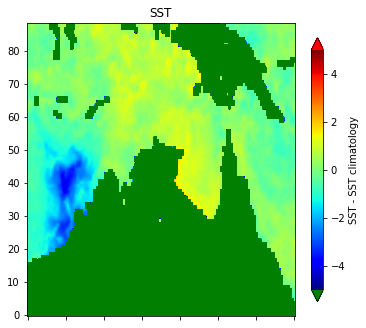

(37, 190, 139) (37, 190, 139)


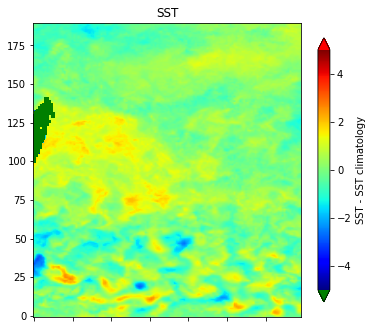

FileNotFoundError: [Errno 2] No such file or directory: b'f:/data/tc_wakes/database/sst/2006\\017_all_25km.nc'

In [30]:
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.mlab as mlab
palette = copy(plt.cm.jet)
palette.set_over('r', 1.0)
palette.set_under('g', 1.0)
palette.set_bad(alpha = 0.0)

dir_ccmp='F:/data/sat_data/ccmp/v02.0/Y'
date_1858 = dt.datetime(1858,11,17,0,0,0) # start date is 11/17/1958
dx=0.25
dy=0.25
dx_offset = -179.875
dy_offset = -78.3750
for root, dirs, files in os.walk(dir_in, topdown=False):
    for ii in range(12,13): 
#    for name in files:
        name = files[ii]
#    for name in files:
        fname_tem=os.path.join(root, name)
        fname_in=dir_out + fname_tem[31:39] + '_all_25km.nc'

        #nc_fid.close()
        nc_fid = Dataset(fname_in, 'r')
        tempgrp = nc_fid.groups['data']
        #tempgrp = nc_fid.createGroup('Eddy_data')
        sst = tempgrp.variables['sst'][:]
        sst_clim = tempgrp.variables['sst_clim'][:]
        wndu = tempgrp.variables['wndu'][:]
        wndv = tempgrp.variables['wndv'][:]
        lon = tempgrp.variables['lon'][:]
        lat = tempgrp.variables['lat'][:]
        time = tempgrp.variables['time'][:]
        nc_fid.close()
        
        sst_diff = sst -273.15 - sst_clim
        print(sst.shape,sst_clim.shape)
        fig, (ax1) = plt.subplots(nrows=1, figsize=(6, 5.4))
        # plot using 'continuous' color map
        im = ax1.imshow(sst_diff[30,:,:], interpolation='bilinear',
                        cmap=palette,
                        norm=colors.Normalize(vmin=-5.0, vmax=5.0),
                        aspect='auto',
                        origin='lower')
                        #extent=[x0, x1, y0, y1])
        ax1.set_title('SST')
        cbar = fig.colorbar(im, extend='both', shrink=0.9, ax=ax1)
        cbar.set_label('SST - SST climatology')
        for ticklabel in ax1.xaxis.get_ticklabels():
            ticklabel.set_visible(False)
        plt.show()
        

In [ ]:
    
from copy import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.mlab as mlab
palette = copy(plt.cm.jet)
palette.set_over('r', 1.0)
palette.set_under('g', 1.0)
palette.set_bad(alpha = 0.0)
fig, (ax1) = plt.subplots(nrows=1, figsize=(6, 5.4))
# plot using 'continuous' color map
im = ax1.imshow(coarse_sst, interpolation='bilinear',
                cmap=palette,
                norm=colors.Normalize(vmin=-2.0, vmax=32.0),
                aspect='auto',
                origin='lower')
                #extent=[x0, x1, y0, y1])
ax1.set_title('SST')
cbar = fig.colorbar(im, extend='both', shrink=0.9, ax=ax1)
cbar.set_label('uniform')
for ticklabel in ax1.xaxis.get_ticklabels():
    ticklabel.set_visible(False)
plt.show()

In [27]:
dir_ccmp='F:/data/sat_data/ccmp/v02.0/Y' 
fname_tem='/CCMP_Wind_Analysis_' + syr + smon.zfill(2) + sdym.zfill(2) + '_V02.0_L3.0_RSS.nc'
ccmp_filename = dir_ccmp + syr + '/M' + smon + fname_tem      
#ccmp_clim_filename='F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_' + sjdy.zfill(3) +'.nc'
print(ccmp_filename)
nc_fid = Dataset(ccmp_filename, 'r')
tem = nc_fid.variables['uwnd'][:]
tem2 = np.append(tem[:,721:],tem[:,:721], axis=1)               
nc_fid.close()
print(tem.shape)
print(tem2.shape)

F:/data/sat_data/ccmp/v02.0/Y2003/M10/CCMP_Wind_Analysis_20031007_V02.0_L3.0_RSS.nc
(4, 628, 1440)
(4, 628, 1440)


In [29]:
nc_fid3.close()
nc_fid4.close()


In [36]:
sst_out[1:5,1:5]

masked_array(
  data=[[298.86931359999994, 299.13495679999994, 299.4799584,
         299.4428431999999],
        [299.1005616000001, 299.2981504, 299.5536448, 299.49326399999995],
        [299.1568272, 299.32557439999994, 299.4448767999999,
         299.51761919999996],
        [299.1576512, 299.31428159999996, 299.4659904,
         299.72692479999995]],
  mask=[[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]],
  fill_value=1e+20)

In [82]:

dir_ccmp='F:/data/sat_data/ccmp/v02.0/Y'
date_1858 = dt.datetime(1858,11,17,0,0,0) # start date is 11/17/1958
dx=0.25
dy=0.25
dx_offset = -179.875
dy_offset = -78.3750
for root, dirs, files in os.walk(dir_in, topdown=False):
#    for ii in range(12,13): 
    for name in files:
    #    name = files[ii]
#    for name in files:
        fname_in=os.path.join(root, name)
        fname_out=dir_out + fname_in[31:39] + '_all_25km.nc'
        inum_storm=int(fname_in[36:39])
        iyr_storm=int(fname_in[31:35])
        if iyr_storm<2005:
            continue
        if iyr_storm==2005 and inum_storm<70:
            continue
        print(name,fname_in)
        dsx = xr.open_dataset(fname_in)
        lats = dsx.lat
        lons = dsx.lon
        dysince = dsx.time
        len_lons = lons.shape
        minlon=min(lons[0,:].values)-10
        maxlon=max(lons[0,:].values)+10
        minlat=min(lats[0,:].values)-10
        maxlat=max(lats[0,:].values)+10
        #here is a fix for when a storm goes from 350 across 360 to 1 2 longitude
        if lons[0,1].values>180 and lons[0,-1].values<180:
            wrap_lons = ((lons+180) % 360) - 180        
            minlon=min(wrap_lons[0,:].values)-10
            maxlon=max(wrap_lons[0,:].values)+10
        if minlon<0:
            minlon=minlon+360
        if maxlon>360:
            maxlon=maxlon-360
        print(minlon,maxlon,minlat,maxlat)
        print(lons)
        #print(wrap_lons)
        break



070annual_storm_info.nc f:/data/tc_wakes/database/info/2005\070annual_storm_info.nc
293.20000126957893 10.0 8.799999579787254 73.4999985806644
<xarray.DataArray 'lon' (j2: 1, i2: 51)>
array([[314.500001, 313.800001, 312.800001, 311.700001, 310.600001,
        309.800001, 309.000001, 308.000001, 306.900001, 306.000001,
        305.400001, 304.900001, 304.500001, 304.000001, 303.500001,
        303.200001, 303.200001, 303.300001, 303.400001, 303.500001,
        304.000001, 304.600001, 305.400001, 306.700001, 308.200001,
        309.200001, 310.100001, 311.000001, 312.000001, 312.800001,
        313.600001, 315.100001, 316.600001, 317.900001, 319.400001,
        320.800001, 322.300001, 323.700001, 325.000001, 326.000001,
        327.100001, 328.000001, 329.000001, 331.000001, 334.000001,
        337.000001, 339.      , 341.      , 344.      , 350.      ,
          0.      ]])
Dimensions without coordinates: j2, i2
001annual_storm_info.nc f:/data/tc_wakes/database/info/2006\001annual_storm

In [62]:
print(lons[0,1].values,lons[0,len_lon[1]].values)
lons

NameError: name 'len_lon' is not defined

In [110]:
 
minlon=10
maxlon=293
ix1=int(round((minlon-dx_offset)/dx))
ix2=int(round((maxlon-dx_offset)/dx))
print(ix1,ix2,)
 

<xarray.DataArray 'lon' (j2: 1, i2: 51)>
array([[314.500001, 313.800001, 312.800001, 311.700001, 310.600001,
        309.800001, 309.000001, 308.000001, 306.900001, 306.000001,
        305.400001, 304.900001, 304.500001, 304.000001, 303.500001,
        303.200001, 303.200001, 303.300001, 303.400001, 303.500001,
        304.000001, 304.600001, 305.400001, 306.700001, 308.200001,
        309.200001, 310.100001, 311.000001, 312.000001, 312.800001,
        313.600001, 315.100001, 316.600001, 317.900001, 319.400001,
        320.800001, 322.300001, 323.700001, 325.000001, 326.000001,
        327.100001, 328.000001, 329.000001, 331.000001, 334.000001,
        337.000001, 339.      , 341.      , 344.      , 350.      ,
          0.      ]])
Dimensions without coordinates: j2, i2
293.20000126957893
10.0


In [ ]:
            if ix1<=1440 and ix2<=1440 and iwrap==0:
                if i==0:
                    print('inside1',iy1,iy2,ix1,ix2)
                sst_out = coarse_sst[iy1:iy2,ix1:ix2]
                mlat_out = coarse_mlat[iy1:iy2]
                mlon_out = coarse_mlon[ix1:ix2]
                sst_clim_out = coarse_sst_clim[iy1:iy2,ix1:ix2]
                wndu_out = wndu[iy1:iy2,ix1:ix2]
                wndu_clim_out = wndu_clim[iy1:iy2,ix1:ix2]
                wndv_out = wndv[iy1:iy2,ix1:ix2]
                wndv_clim_out = wndv_clim[iy1:iy2,ix1:ix2]
            if ix1>1440 and ix2>1440:
                if i==0:
                    print('inside2',iy1,iy2,ix1,ix2)
                sst_out = coarse_sst[iy1:iy2,ix1-1440:ix2-1440]
                mlat_out = coarse_mlat[iy1:iy2]
                mlon_out = coarse_mlon[ix1-1440:ix2-1440]
                sst_clim_out = coarse_sst_clim[iy1:iy2,ix1-1440:ix2-1440]
                wndu_out = wndu[iy1:iy2,ix1-1440:ix2-1440]
                wndu_clim_out = wndu_clim[iy1:iy2,ix1-1440:ix2-1440]
                wndv_out = wndv[iy1:iy2,ix1-1440:ix2-1440]
                wndv_clim_out = wndv_clim[iy1:iy2,ix1-1440:ix2-1440]
            if ix1<=1440 and ix2>1440:
                if i==0:
                    print('inside3',iy1,iy2,ix1,ix2)
                tem1 = coarse_sst[iy1:iy2,ix1:]
                tem2 = coarse_sst[iy1:iy2,:ix2-1440]
                sst_out = np.append(tem1,tem2, axis=1)
                mlat_out = coarse_mlat[iy1:iy2]
                mlon1 = coarse_mlon[ix1:]
                mlon2 = coarse_mlon[:ix2-1440]
                print(mlon1.shape,mlon2.shape)
                mlon_out = np.append(mlon1,mlon2, axis=0)               
                tem1 = coarse_sst_clim[iy1:iy2,ix1:]
                tem2 = coarse_sst_clim[iy1:iy2,:ix2-1440]
                sst_clim_out = np.append(tem1,tem2, axis=1)

                tem1 = wndu[iy1:iy2,ix1:]
                tem2 = wndu[iy1:iy2,:ix2-1440]
                wndu_out = np.append(tem1,tem2, axis=1)
                tem1 = wndv[iy1:iy2,ix1:]
                tem2 = wndv[iy1:iy2,:ix2-1440]
                wndv_out = np.append(tem1,tem2, axis=1)
                tem1 = wndu_clim[iy1:iy2,ix1:]
                tem2 = wndu_clim[iy1:iy2,:ix2-1440]
                wndu_clim_out = np.append(tem1,tem2, axis=1)
                tem1 = wndv_clim[iy1:iy2,ix1:]
                tem2 = wndv_clim[iy1:iy2,:ix2-1440]
                wndv_clim_out = np.append(tem1,tem2, axis=1)
                
            if ix1>1440 and ix2<1440:
                if i==0:
                    print('inside4',iy1,iy2,ix1,ix2)
                tem1 = coarse_sst[iy1:iy2,ix2:]
                tem2 = coarse_sst[iy1:iy2,:ix1-1440]
                sst_out = np.append(tem1,tem2, axis=1)
                mlat_out = coarse_mlat[iy1:iy2]
                mlon1 = coarse_mlon[ix2:]
                mlon2 = coarse_mlon[:ix1-1440]
                print(mlon1.shape,mlon2.shape)
                mlon_out = np.append(mlon1,mlon2, axis=0)               
                sst1 = coarse_sst_clim[iy1:iy2,ix2:]
                sst2 = coarse_sst_clim[iy1:iy2,:ix1-1440]
                sst_clim_out = np.append(sst1,sst2, axis=1)

                tem1 = wndu[iy1:iy2,ix2:]
                tem2 = wndu[iy1:iy2,:ix1-1440]
                wndu_out = np.append(tem1,tem2, axis=1)
                tem1 = wndv[iy1:iy2,ix2:]
                tem2 = wndv[iy1:iy2,:ix1-1440]
                wndv_out = np.append(tem1,tem2, axis=1)
                tem1 = wndu_clim[iy1:iy2,ix2:]
                tem2 = wndu_clim[iy1:iy2,:ix1-1440]
                wndu_clim_out = np.append(tem1,tem2, axis=1)
                tem1 = wndv_clim[iy1:iy2,ix2:]
                tem2 = wndv_clim[iy1:iy2,:ix1-1440]
                wndv_clim_out = np.append(tem1,tem2, axis=1)
                
            if i==0:
                print('sst',sst_out.shape,'sst_sv',sst_out_sv.shape)
                print('mlon',mlon_out.shape,'mlat',mlat_out.shape)
            #sst_sv[i,:,:]=sst-sst_clim
            sst_out_sv[i,:,:]=sst_out
            sst_clim_out_sv[i,:,:]=sst_clim_out
            wndu_out_sv[i,:,:]=wndu_out
            wndv_out_sv[i,:,:]=wndv_out
            wndu_clim_out_sv[i,:,:]=wndu_clim_out
            wndv_clim_out_sv[i,:,:]=wndv_clim_out
            
        ilen=len(fname_in)
        
        dif_dys=[0]*tdim
        for i in range(0,tdim):
            dif_dys[i] = i

        print('file out:',fname_out)
        #f.close()
        f = Dataset(fname_out,'w', format='NETCDF4') 
        tempgrp = f.createGroup('data')
        tempgrp.setncattr_string('start time',str(tem_date[0]))
        tempgrp.createDimension('t', tdim)
        tempgrp.createDimension('y', ydim)
        tempgrp.createDimension('x', xdim)

    #tem_date[i]
        sst_netcdf = tempgrp.createVariable('sst', 'f4', ('t', 'y', 'x'))
        sst_clim_netcdf = tempgrp.createVariable('sst_clim', 'f4', ('t', 'y', 'x'))
        wndu_netcdf = tempgrp.createVariable('wndu', 'f4', ('t', 'y', 'x'))
        wndv_netcdf = tempgrp.createVariable('wndv', 'f4', ('t', 'y', 'x'))
        wndu_clim_netcdf = tempgrp.createVariable('wndu_clim', 'f4', ('t', 'y', 'x'))
        wndv_clim_netcdf = tempgrp.createVariable('wndv_clim', 'f4', ('t', 'y', 'x'))
        longitude = tempgrp.createVariable('lon', 'f4', 'x')
        latitude = tempgrp.createVariable('lat', 'f4', 'y')  
        time = tempgrp.createVariable('time', 'i4', 't')
        
        sst_netcdf[:] = sst_out_sv
        sst_clim_netcdf[:] = sst_clim_out_sv
        wndu_netcdf[:] = wndu_out_sv
        wndv_netcdf[:] = wndv_out_sv
        wndu_clim_netcdf[:] = wndu_clim_out_sv
        wndv_clim_netcdf[:] = wndv_clim_out_sv
        latitude[:] = mlat_out
        longitude[:] = mlon_out
        time[:]=dif_dys
        f.close()
    


In [27]:
dir_ccmp='F:/data/sat_data/ccmp/v02.0/Y'
date_1858 = dt.datetime(1858,11,17,0,0,0) # start date is 11/17/1958
dx=0.25
dy=0.25
dx_offset = -179.875
dy_offset = -78.3750
for root, dirs, files in os.walk(dir_in, topdown=False):
#    for ii in range(12,13): 
    for name in files:
    #    name = files[ii]
#    for name in files:
        fname_in=os.path.join(root, name)
        fname_out=dir_out + fname_in[31:39] + '_all_25km.nc'
        #print(fname_in[31:35],fname_in[36:39])
        inum_storm=int(fname_in[36:39])
        iyr_storm=int(fname_in[31:35])
        #print(iyr_storm,inum_storm)
        dsx = xr.open_dataset(fname_in)
        lats = dsx.lat
        lons = dsx.lon

        maxlon=max(lons[0,:].values+10)
        minlon=min(lons[0,:].values-10)
        #here is a fix for when a storm goes from 350 across 360 to 1 2 longitude
        iwrap=0
        if abs(min(lons[0,:].values)-max(lons[0,:].values))>180:
            lons1=lons[0,:].values-10>180
            lons2=lons[0,:].values+10<180
            maxlon=min(lons[0,lons1].values-10)
            minlon=max(lons[0,lons2].values+10)
            print('wrapped',minlon,maxlon)
            iwrap=1

        #print('min/max lon lat',minlon,maxlon)

        ix1=int(round((minlon-dx_offset)/dx))
        ix2=int(round((maxlon-dx_offset)/dx))
        if ix1 < 0:
            ix1 = ix1 + 1440
        if ix2 < 0:
            ix2 = ix2 + 1440
        xdim=ix2-ix1
        if iwrap==1:
            xdim=ix1-ix2+1440
    
        #print(xdim)
        if iwrap==1:
            print(lons[0,1].values,lons[0,-1].values,ix1,ix2,xdim,iwrap)
        



wrapped 23.499999698251486 300.5000011064112
329.3000006861985 13.499999698251486 813 1922 331 1
wrapped 10.0 293.20000126957893
313.80000103265047 0.0 760 1892 308 1
wrapped 16.599999852478504 270.40000177919865
281.7000017501414 6.599999852478504 786 1801 425 1
wrapped 10.0 279.8000015690923
339.70000045374036 0.0 760 1839 361 1
